# Telco Churn

**Şirketi terk edecek müşterileri tahmin edebilecek bir makine öğrenmesi modeli geliştireceğiz. Modeli geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştireceğiz**

## Veri Seti Hikayesi

**Telco müşteri kaybı verileri, üçüncü çeyrekte Kaliforniya'daki 7043 müşteriye ev telefonu ve İnternet hizmetleri sağlayan hayali
bir telekom şirketi hakkında bilgi içerir. Hangi müşterilerin hizmetlerinden ayrıldığını, kaldığını veya hizmete kaydolduğunu
gösterir.**

CustomerId : Müşteri İd’si

Gender : Cinsiyet

SeniorCitizen: Müşterinin yaşlı olup olmadığı (1, 0)

Partner : Müşterinin bir ortağı olup olmadığı (Evet, Hayır)

Dependents : Müşterinin bakmakla yükümlü olduğu kişiler olup olmadığı (Evet, Hayır)

tenure : Müşterinin şirkette kaldığı ay sayısı

PhoneService : Müşterinin telefon hizmeti olup olmadığı (Evet, Hayır)

MultipleLines : Müşterinin birden fazla hattı olup olmadığı (Evet, Hayır, Telefon hizmeti yok)

InternetService : Müşterinin internet servis sağlayıcısı (DSL, Fiber optik, Hayır)

OnlineSecurity : Müşterinin çevrimiçi güvenliğinin olup olmadığı (Evet, Hayır, İnternet hizmeti yok)

OnlineBackup : Müşterinin online yedeğinin olup olmadığı (Evet, Hayır, İnternet hizmeti yok)

DeviceProtection : Müşterinin cihaz korumasına sahip olup olmadığı (Evet, Hayır, İnternet hizmeti yok)

TechSupport : Müşterinin teknik destek alıp almadığı (Evet, Hayır, İnternet hizmeti yok)

StreamingTV : Müşterinin TV yayını olup olmadığı (Evet, Hayır, İnternet hizmeti yok)

StreamingMovies : Müşterinin film akışı olup olmadığı (Evet, Hayır, İnternet hizmeti yok)

Contract : Müşterinin sözleşme süresi (Aydan aya, Bir yıl, İki yıl)

PaperlessBilling : Müşterinin kağıtsız faturası olup olmadığı (Evet, Hayır)

PaymentMethod : Müşterinin ödeme yöntemi (Elektronik çek, Posta çeki, Banka havalesi (otomatik), Kredi kartı (otomatik))

MonthlyCharges : Müşteriden aylık olarak tahsil edilen tutar

TotalCharges : Müşteriden tahsil edilen toplam tutar

Churn : Müşterinin kullanıp kullanmadığı (Evet veya Hayır)

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

Gerekli Kütüphane ve Fonksiyonları ekledik

In [3]:
df = pd.read_csv("Telco-Customer-Churn.csv")
def check_data(dataframe,head=5):
    print(20*"-" + "Information".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Data Shape".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "The First 5 Data".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe([0.01, 0.05, 0.10, 0.50, 0.75, 0.90, 0.95, 0.99]).T)

check_data(df)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-n

Veri kümesinde eksik değer yok, bu iyi bir şey. Ancak veri türleriyle ilgili birkaç gözlem vardır:

* TotalCharges: Bu sütun şu anda nesne (dize) biçimindedir; bu, sayısal olmayan karakterlerin mevcut olduğunu gösterebilir. Bu sütun ideal olarak analiz için sayısal formatta olmalıdır.

* SeniorCitizen: Bir tam sayıdır (int64), eğer ikili bir gösterge (0 veya 1) olacaksa uygundur. Ancak yaş kategorisi olacaksa bunu da gözden geçirmemiz gerekebilir.

* Müşteri Kimliği: Nesne türü olarak doğru olsa da, bireysel müşterileri takip etmediğimiz sürece bu sütun analiz için gerekli olmayabilir.

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for any new missing values in 'TotalCharges'
new_missing_values = df['TotalCharges'].isnull().sum()
new_missing_values

11

TotalCharges sütununun sayısal formata dönüştürülmesi 11 yeni eksik değerle sonuçlandı. Bunlar muhtemelen orijinal verilerin sayısal olmayan karakterlere veya sayılara dönüştürülemeyen boş dizelere sahip olduğu durumlardır.

Bu eksik değerleri ele almak için birkaç seçeneğimiz var:

Satırları Kaldırın: Veri kümesi yeterince büyükse 11 satırın kaldırılması analizi önemli ölçüde etkilemeyebilir.

Değerleri Değerlendirin: Bu eksik değerleri ortalama, medyan gibi bir istatistikle veya diğer sütunlara dayalı bir değerle doldurabiliriz (örneğin, Toplam Ücretleri tahmin etmek için Aylık Ücretleri ve görev süresini kullanarak).

Daha Fazla Araştırın: Karar vermeden önce, değerlerin neden eksik olduğunu anlamak için bu belirli satırlara bakmak isteyebiliriz.

In [5]:
missing_total_charges_rows = df[df['TotalCharges'].isnull()]
missing_total_charges_rows

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,NaN,No


Toplam Ücretlerin eksik olduğu satırlar incelendiğinde bir model ortaya çıkıyor: tüm bu müşterilerin kullanım süresi 0'dır. Bu, bu müşterilerin yeni olduğunu ve henüz faturalandırılmadığını gösterir; bu da toplam ücretlerin yokluğunu açıklar.

In [6]:
df['TotalCharges'].fillna(0, inplace=True)
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
df.drop('customerID', axis=1, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,Yes


Veri kümesi üzerinde Keşifsel Veri Analizi (EDA) gerçekleştireceğiz. EDA, veri içindeki dağılımı, eğilimleri ve ilişkileri anlamamıza yardımcı olduğundan veri analizinde çok önemli bir adımdır. İşte EDA'mız için bir plan:

1. **Özet İstatistikler:** Sayısal sütunlar için temel özet istatistiklerle başlayacağız.
2. **Değişkenlerin Dağılımı:** Hem sayısal ("görev süresi", "Aylık Ücretler", "Toplam Ücretler" gibi) hem de kategorik ("cinsiyet", "InternetService", "Sözleşme" gibi) temel değişkenlerin dağılımını analiz edin.
3. **Korelasyon Analizi:** Sayısal değişkenler arasındaki korelasyonları inceleyin.
4. **Churn Analizi:** Hedef değişken "Churn" olduğundan, özellikle farklı değişkenlerin aboneyi kaybetme oranlarıyla nasıl ilişkili olduğuna odaklanacağız.
5. **Görselleştirmeler:** Verileri görselleştirmek ve kalıpları ortaya çıkarmak için çeşitli grafikler (histogramlar, çubuk grafikler, kutu grafikleri ve dağılım grafikleri gibi) kullanacağız.


In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
 
   # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 20
cat_cols: 17
num_cols: 3
cat_but_car: 0
num_but_cat: 1


## Numerik Değişkenler

In [9]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [10]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.000,32.371,24.559,0.000,9.000,29.000,55.000,72.000
MonthlyCharges,7043.000,64.762,30.090,18.250,35.500,70.350,89.850,118.750
TotalCharges,7043.000,2279.734,2266.794,0.000,398.550,1394.550,3786.600,8684.800


### Yorumlar

Tenure : Ortalama tenure(görev süresi) yaklaşık 32 aydır ve geniş bir aralıktadır (0 ila 72 ay), bu da yeni ve uzun vadeli müşterilerin bir karışımını gösterir.

Aylık Ücretler: Ortalama aylık ücret yaklaşık 64,76 ABD Doları olup, ücretler 18,25 ile 118,75 ABD Doları arasında değişmektedir.

Toplam Ücretler: Toplam ücretler büyük farklılıklar gösterir ve ortalama 2279,73 USD civarındadır. Dağıtım çarpıktır ve maksimum ücret 8684,80 USD'dir.


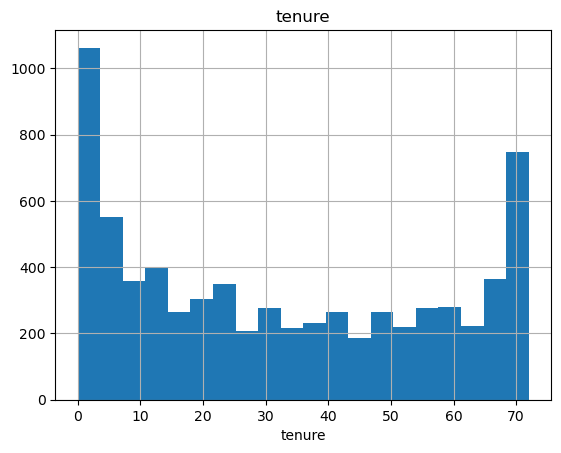

count   7043.000
mean      32.371
std       24.559
min        0.000
10%        2.000
20%        6.000
40%       20.000
50%       29.000
60%       40.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


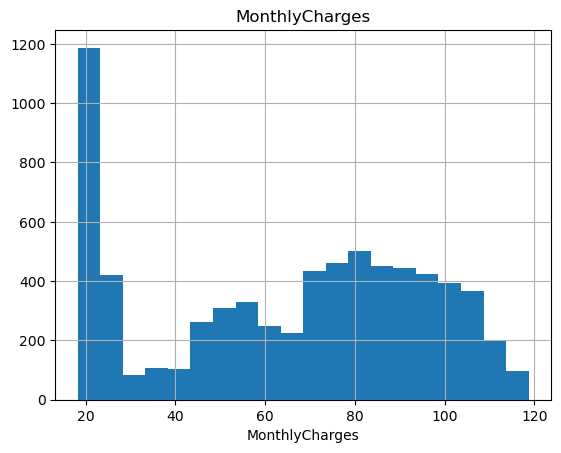

count   7043.000
mean      64.762
std       30.090
min       18.250
10%       20.050
20%       25.050
40%       58.830
50%       70.350
60%       79.100
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


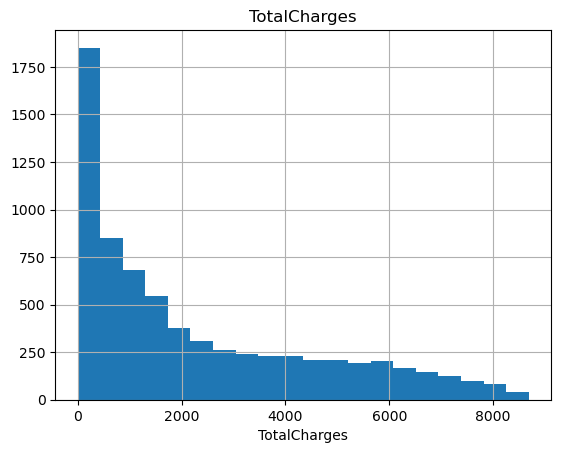

count   7043.000
mean    2279.734
std     2266.794
min        0.000
10%       83.470
20%      265.320
40%      939.780
50%     1394.550
60%     2043.710
80%     4471.440
90%     5973.690
95%     6921.025
99%     8039.256
max     8684.800
Name: TotalCharges, dtype: float64


In [11]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.10, 0.20, 0.40, 0.50, 0.60, 0.80, 0.90, 0.95, 0.99]

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
        print(dataframe[numerical_col].describe(quantiles).T)


for col in num_cols:
    num_summary(df, col, plot=True)

### Yorum

* Tenure(Görev süresi): Dağılım, önemli sayıda yeni müşteriyi (düşük kullanım süresi) ve önemli sayıda uzun vadeli müşteriyi (yüksek kullanım süresi) gösteren iki zirve göstermektedir. Bu iki modlu dağılım, şirketteki süreleri açısından iki ana müşteri grubunu akla getiriyor.


* Aylık Ücretler: Dağıtım biraz iki modludur; bir tepe noktası alt uçta (yaklaşık 20 ABD Doları) ve diğeri üst uçta (yaklaşık 80-90 ABD Doları) bulunur. Bu, abone oldukları hizmetlere göre farklı müşteri gruplarının bulunduğunu gösteriyor; bazıları temel, daha düşük maliyetli hizmetleri, diğerleri ise daha pahalı paketleri tercih ediyor.


* Toplam Masraflar: Dağıtım sağa çarpıktır, bu da çok sayıda müşterinin nispeten daha düşük toplam ücretlere sahip olduğunu gösterir; bu da önemli sayıda müşterinin daha düşük kullanım süresine sahip olduğuyla uyumludur


## Kategorik Değişkenler

In [12]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'SeniorCitizen']

In [13]:
df[cat_cols].describe(include=["object"])

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


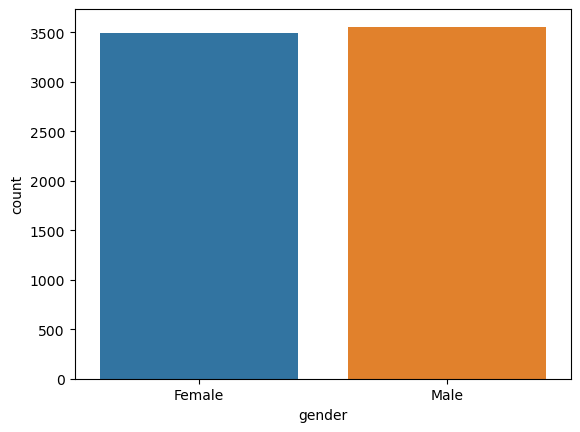

        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
##########################################


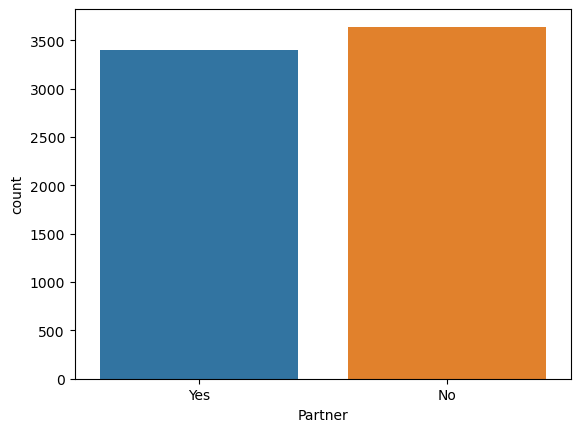

         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
##########################################


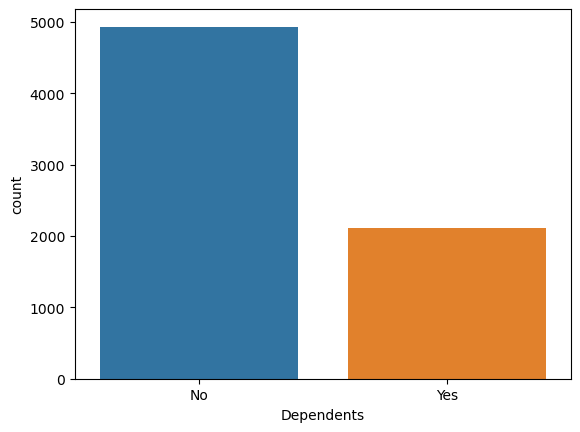

            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
##########################################


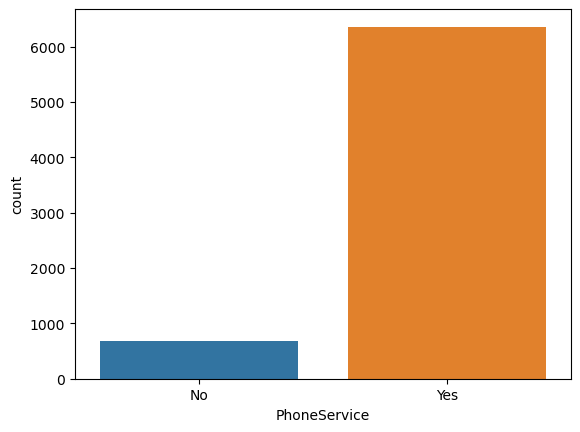

              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
##########################################


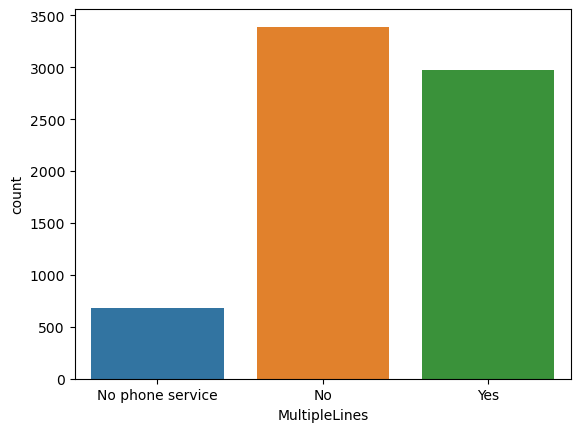

                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################


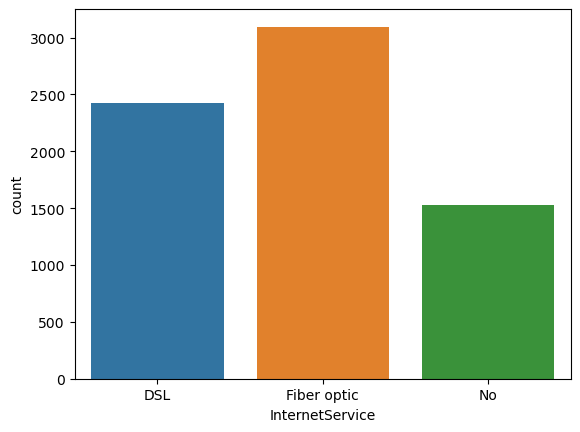

                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         2421 34.375
No                          1526 21.667
##########################################


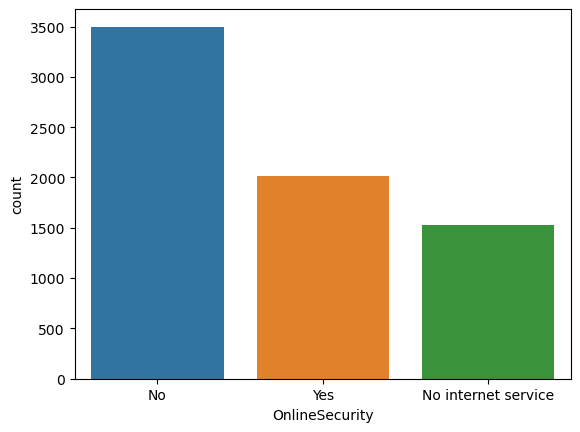

                     OnlineSecurity  Ratio
OnlineSecurity                            
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667
##########################################


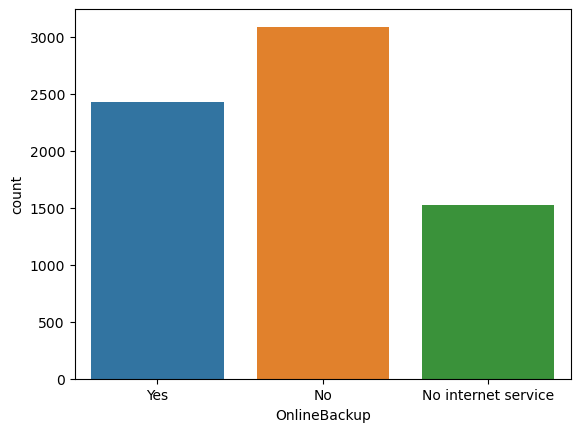

                     OnlineBackup  Ratio
OnlineBackup                            
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667
##########################################


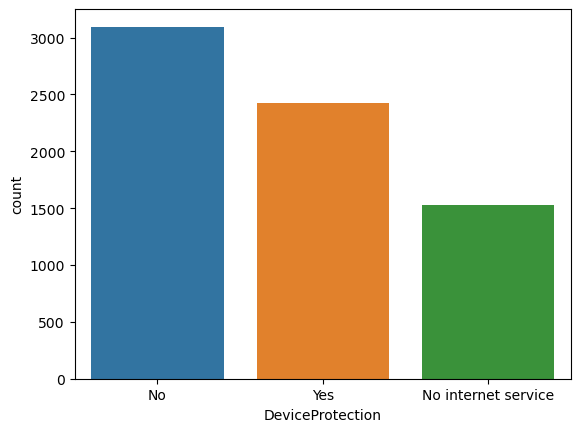

                     DeviceProtection  Ratio
DeviceProtection                            
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667
##########################################


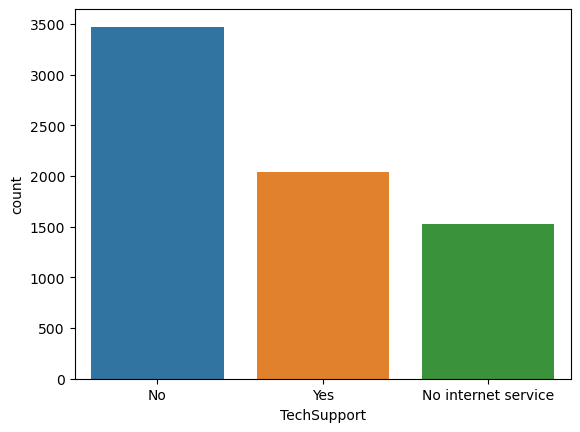

                     TechSupport  Ratio
TechSupport                            
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667
##########################################


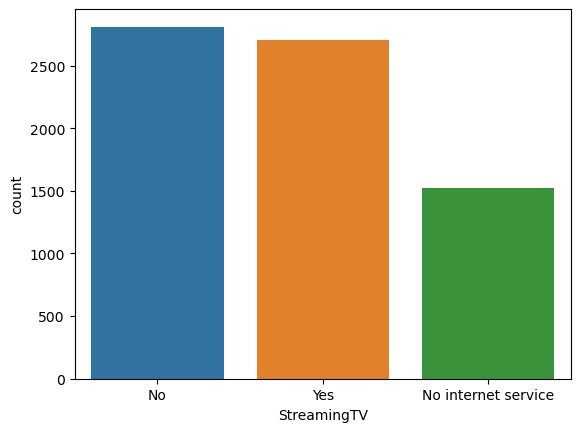

                     StreamingTV  Ratio
StreamingTV                            
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667
##########################################


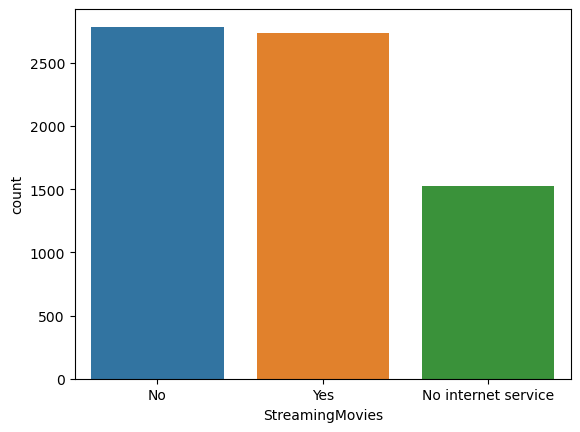

                     StreamingMovies  Ratio
StreamingMovies                            
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667
##########################################


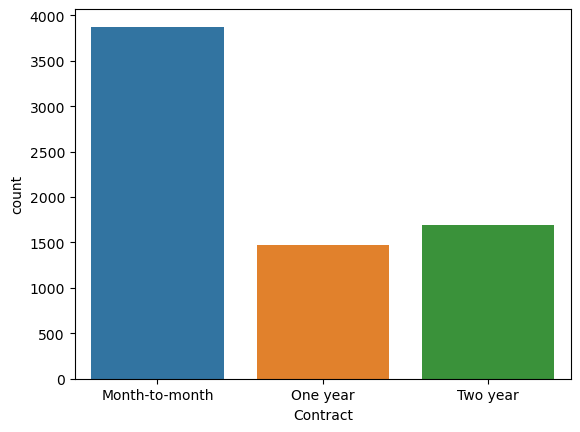

                Contract  Ratio
Contract                       
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914
##########################################


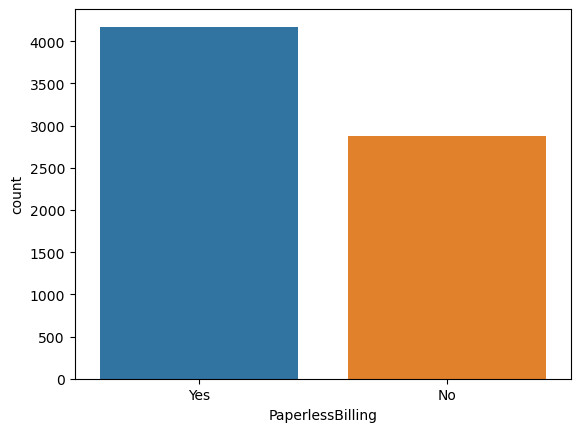

                  PaperlessBilling  Ratio
PaperlessBilling                         
Yes                           4171 59.222
No                            2872 40.778
##########################################


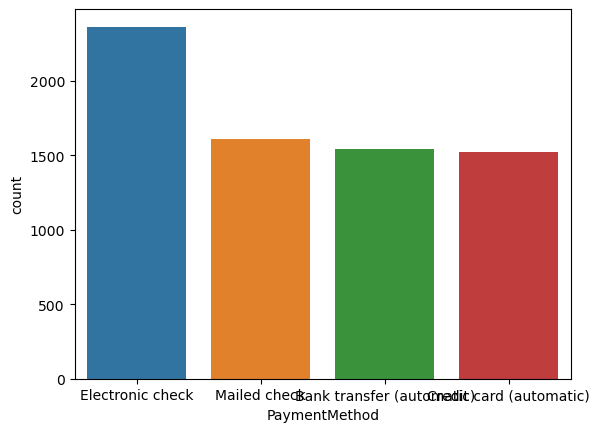

                           PaymentMethod  Ratio
PaymentMethod                                  
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610
##########################################


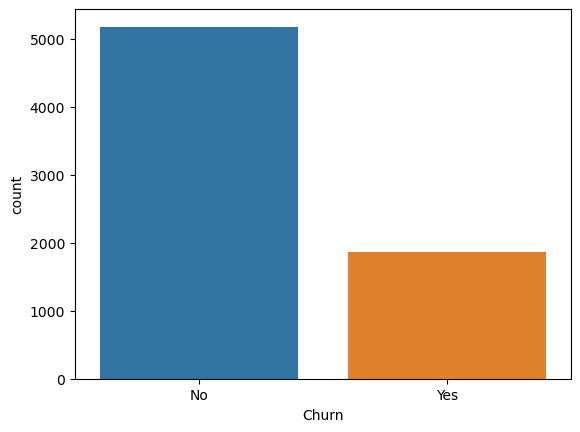

       Churn  Ratio
Churn              
No      5174 73.463
Yes     1869 26.537
##########################################


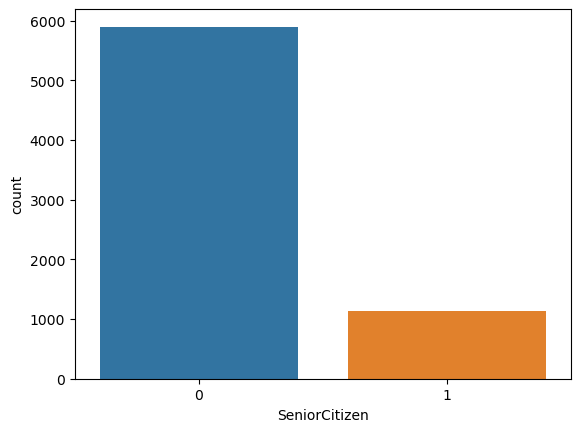

               SeniorCitizen  Ratio
SeniorCitizen                      
0                       5901 83.785
1                       1142 16.215
##########################################


In [14]:
def cat_summary(dataframe, col_name, plot=False):
    
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")


for col in cat_cols:
    cat_summary(df, col,plot=True)

### Yorumlar

* Cinsiyet: Erkek ve kadın müşteri sayısı hemen hemen eşittir.

* Ortak ve Bağımlı Kişiler: Biraz daha fazla sayıda müşterinin ortağı veya bakmakla yükümlü olduğu kişiler yoktur.

* PhoneService: Çoğu müşterinin (yaklaşık %90'ı) telefon hizmeti vardır.

* MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies: 
Bu sütunlar çeşitli kategorilere sahiptir ve müşterilerin çoğunluğu çevrimiçi güvenlik, teknik destek vb. ek hizmetlere sahip değildir.

* Contract: En yaygın sözleşme türü aydan ayadır.

* PaperlessBilling: Müşterilerin çoğunluğu (yaklaşık %59) kağıtsız faturalandırmayı kullanıyor.

* PaymentMethod: En yaygın ödeme yöntemi elektronik çektir.

* Churn: Kaybetme sütunundaki 'Hayır' sıklığının gösterdiği gibi, kaybetme oranı elde tutma oranından daha düşüktür.

## Churn Analizi

In [15]:
df["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [16]:
df["Churn"] = df["Churn"].map({'No':0,'Yes':1})

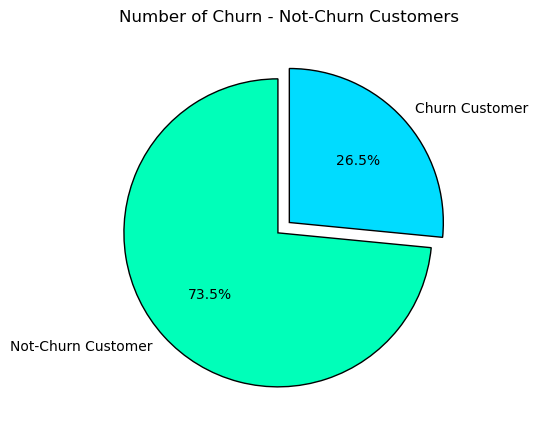

In [17]:
colors = ['#00FFB9','#00DCFF']


l = list(df['Churn'].value_counts())
circle = [l[0] / sum(l) * 100,l[1] / sum(l) * 100]

fig = plt.subplots(figsize = (20,5))
plt.pie(circle,labels = ['Not-Churn Customer','Churn Customer'],autopct = '%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Churn - Not-Churn %');

plt.title('Number of Churn - Not-Churn Customers');
plt.show()

Müşteri Kayıp Dağılımı grafiği ve hesaplanan kayıp oranı aşağıdaki bilgileri sağlar:

* Müşterilerin yaklaşık %73,46'sı ayrılmadı, bu da çoğunluğun istikrarlı müşteriler olduğunu gösteriyor.

* Müşterilerin yaklaşık %26,54'ü işten ayrıldı; bu önemli bir orandır ve işletme için endişe kaynağı olabilir.

* Bu kayıp oranı, müşteri kaybına katkıda bulunan faktörlerin anlaşılmasının önemini vurgulamaktadır. İşletmeler bu bilgileri müşteri tutmayı iyileştirmeye yönelik stratejiler geliştirmek için kullanabilir.

## Kategorik Değişkenler vs Hedef Değişken (Churn):


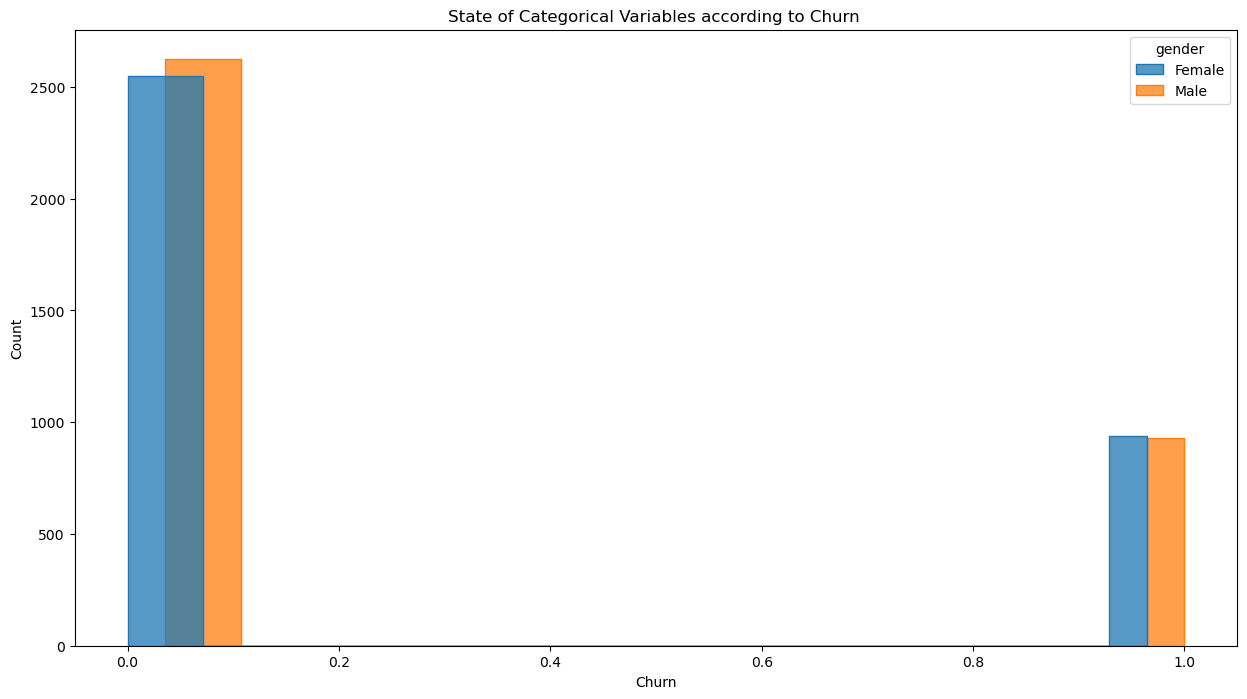

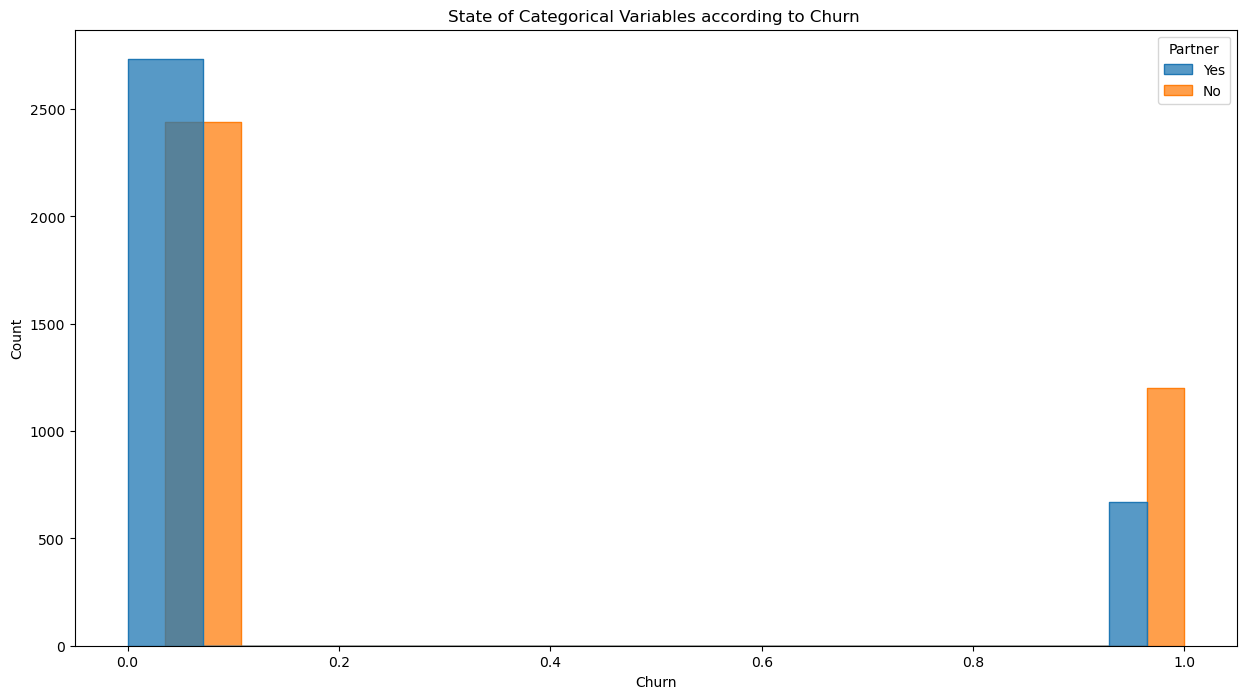

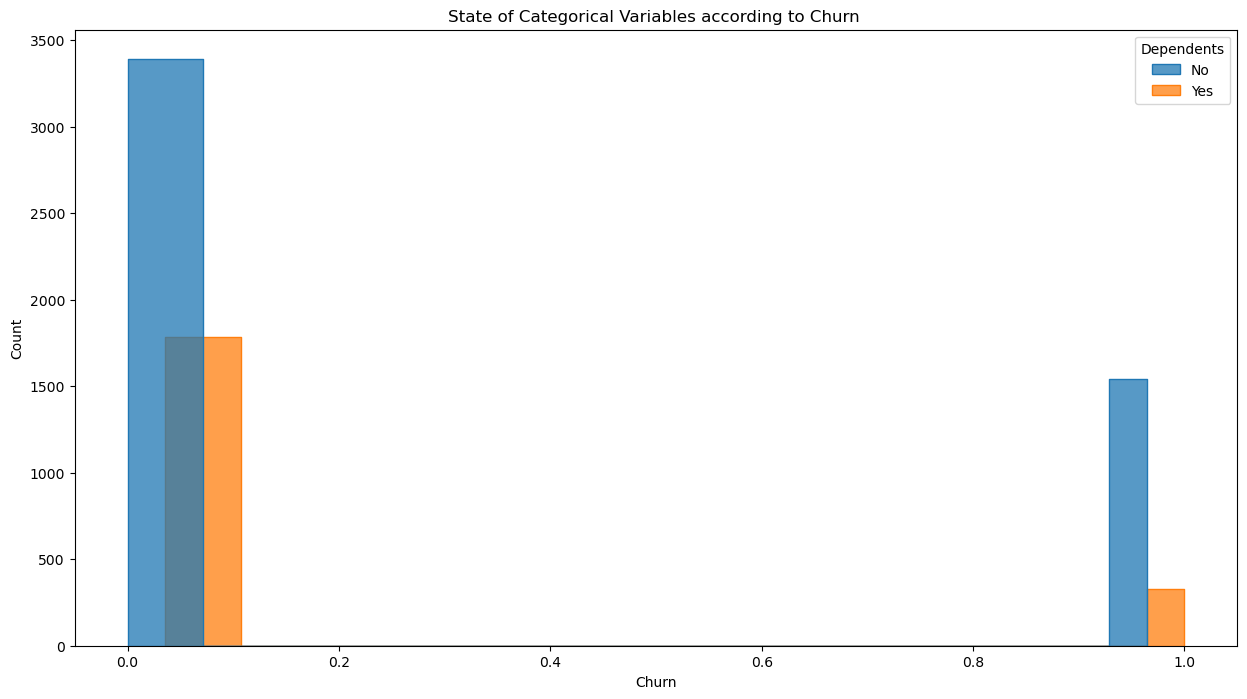

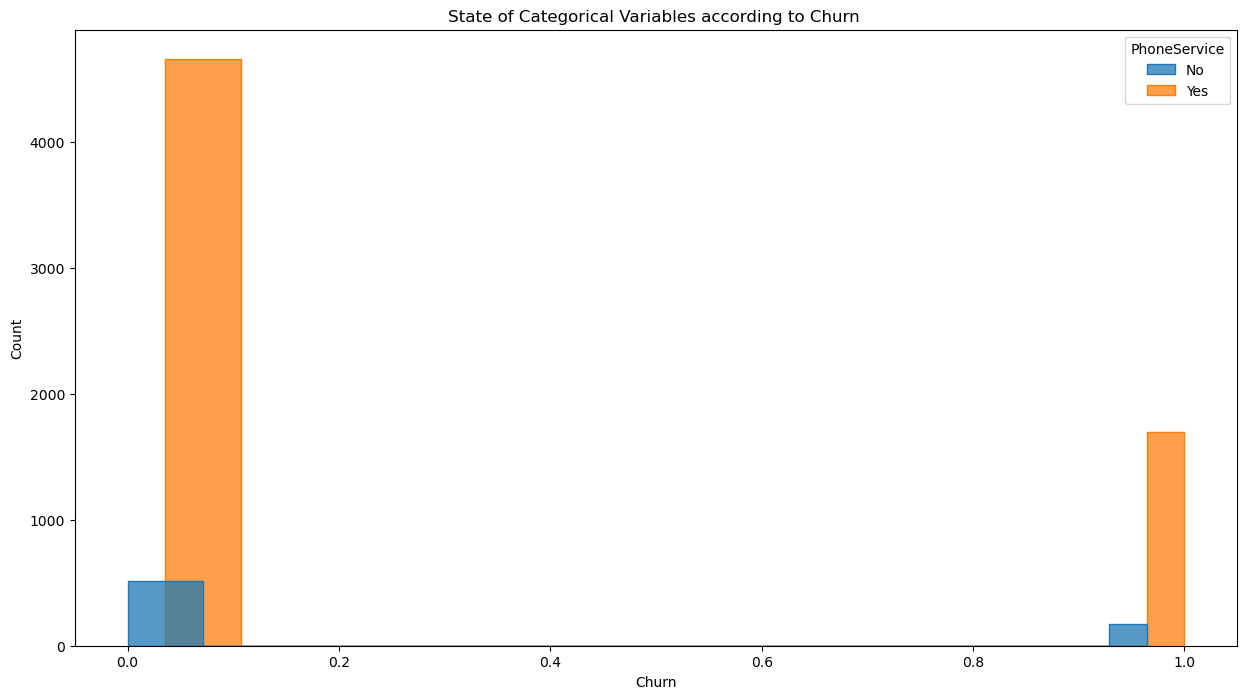

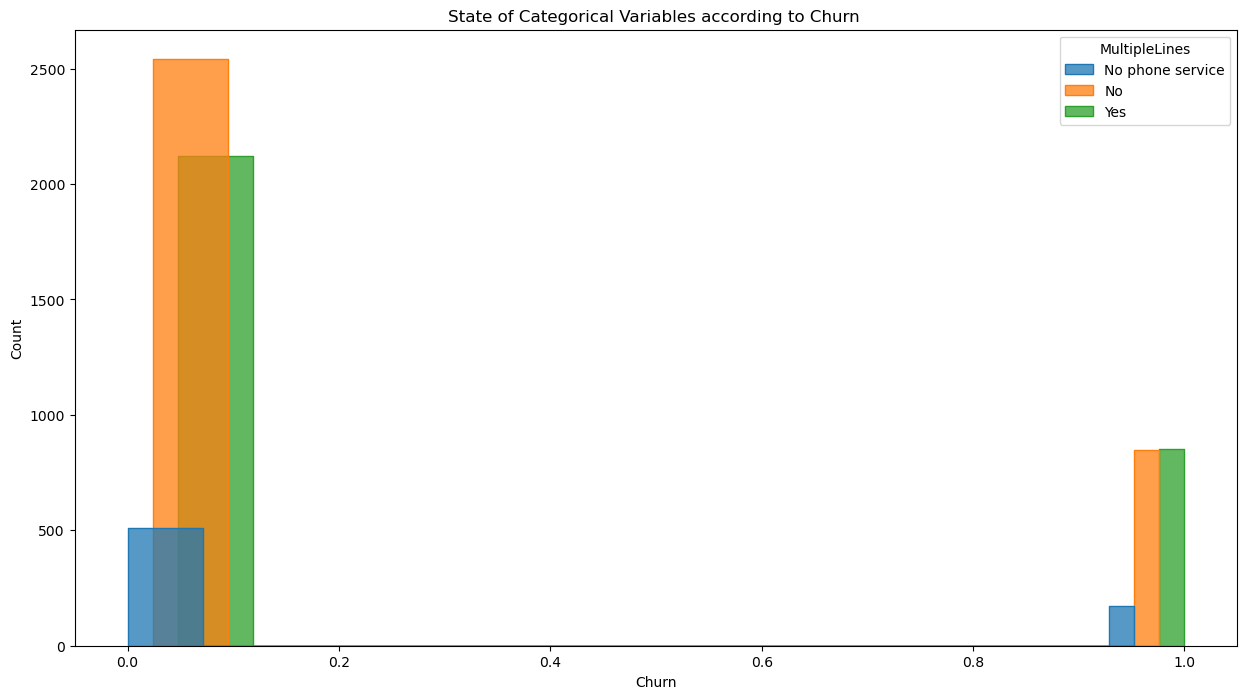

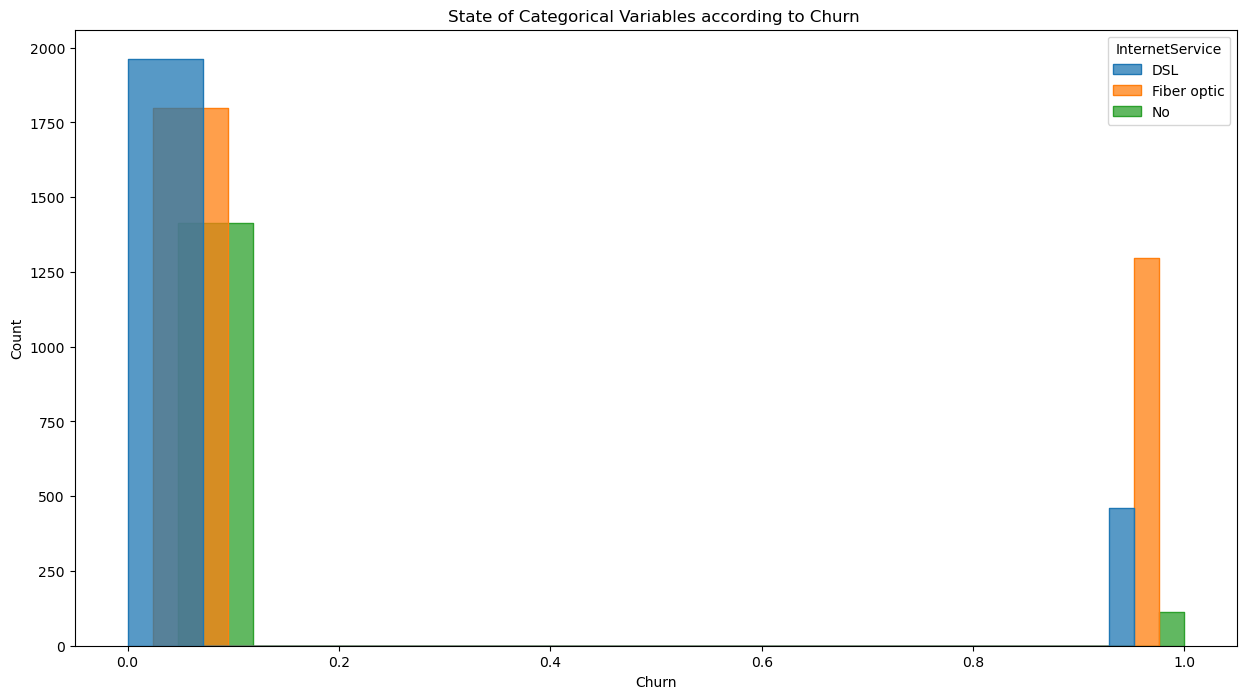

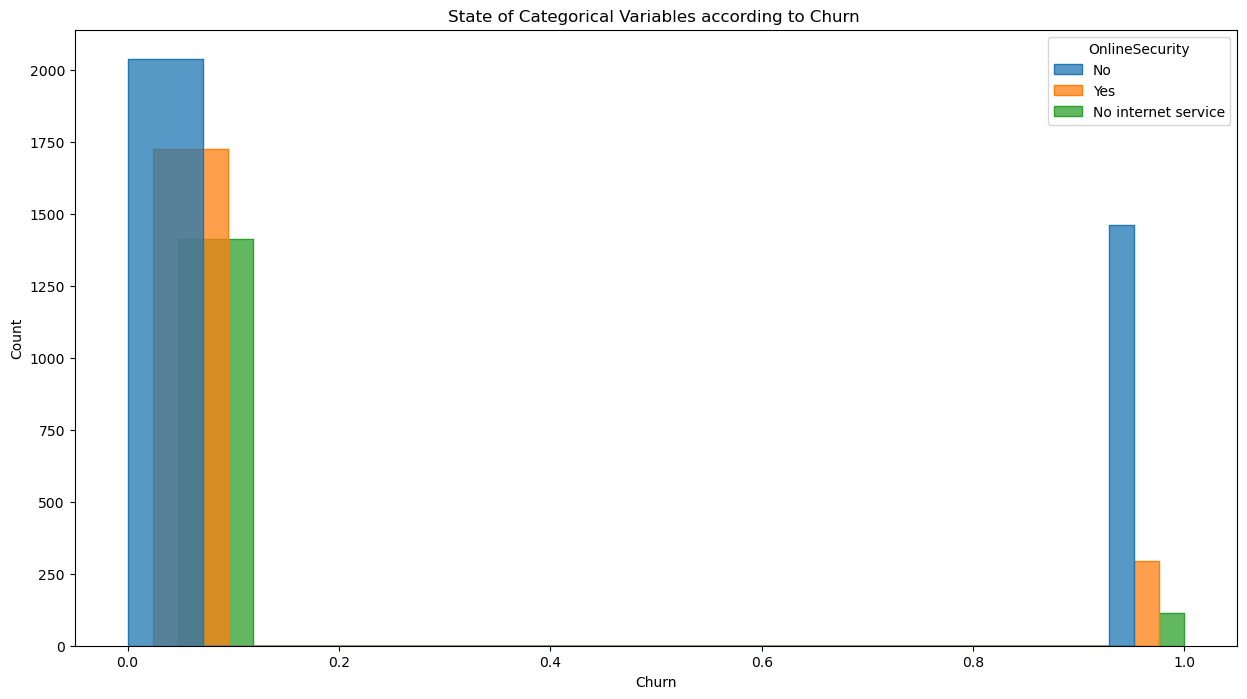

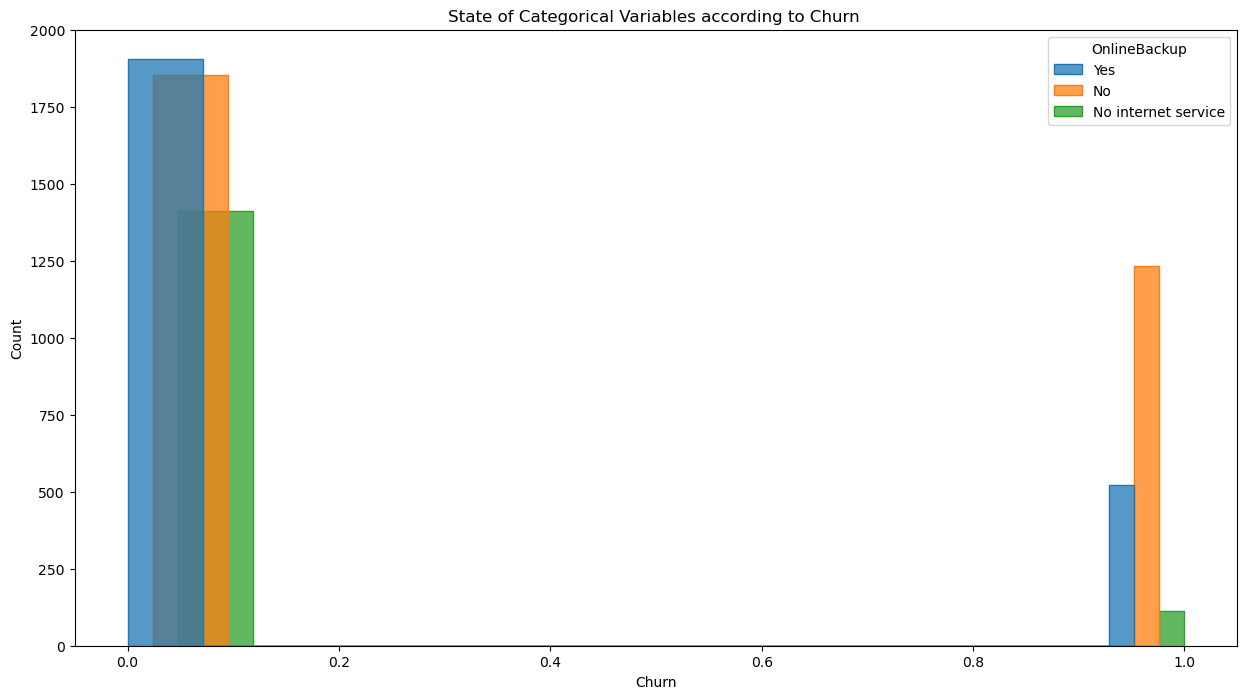

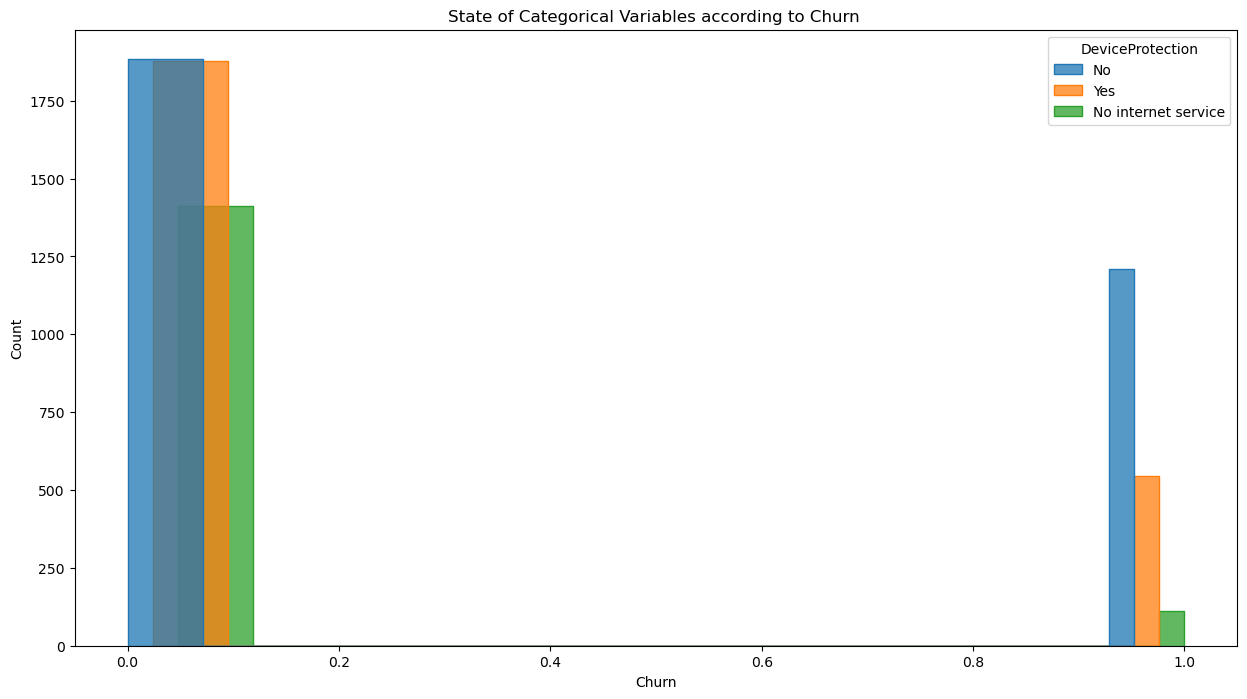

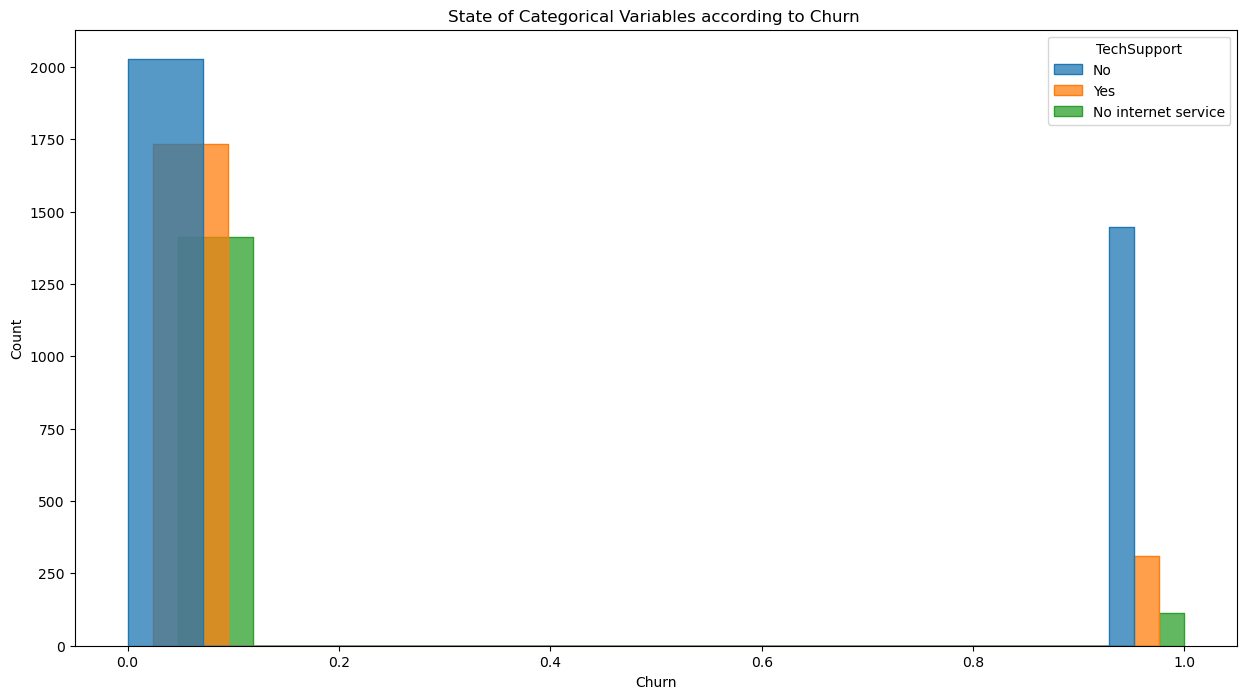

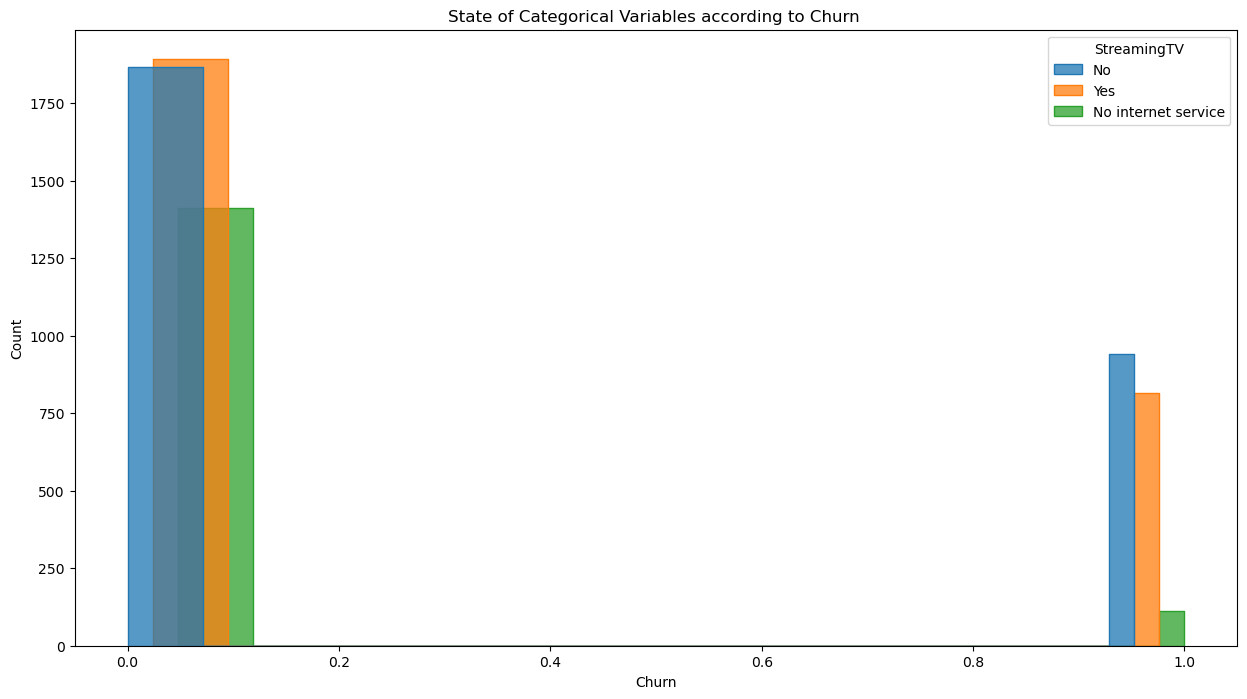

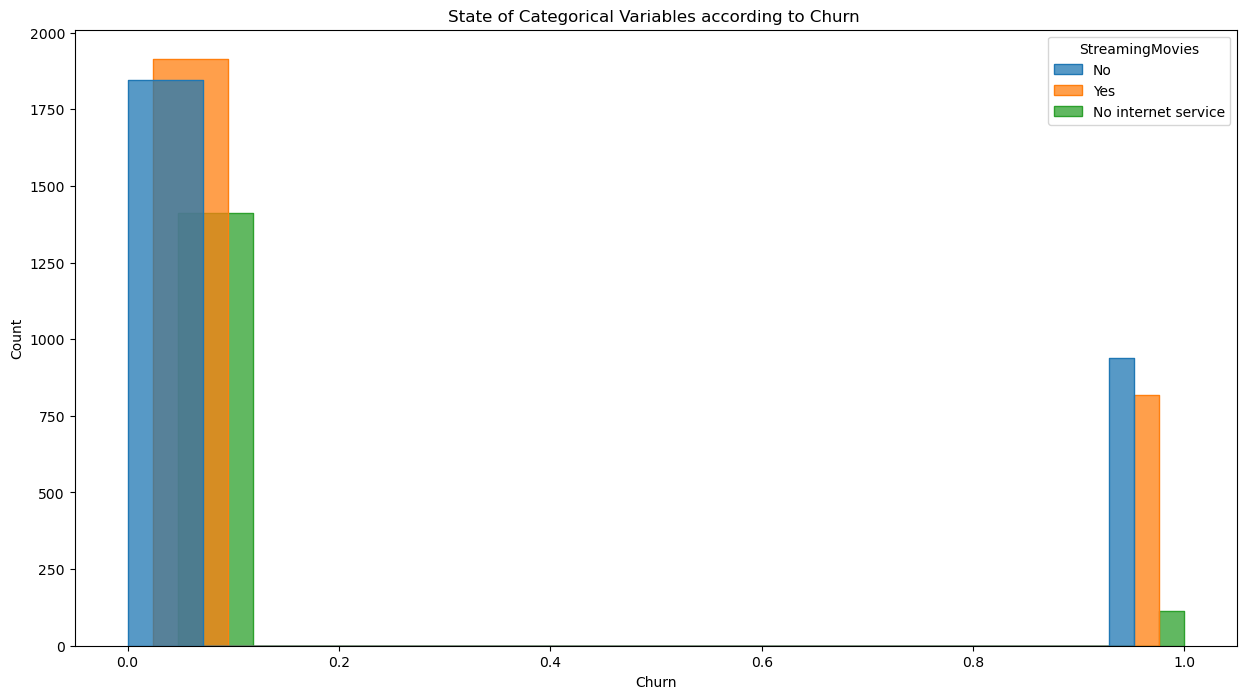

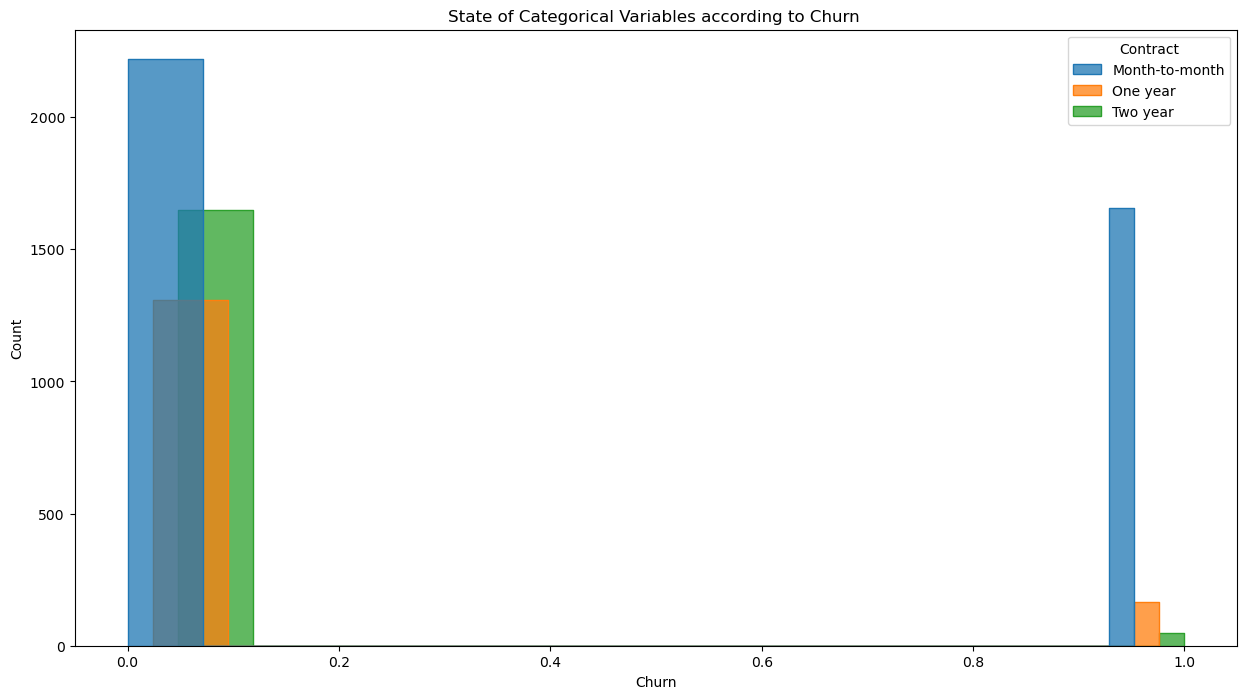

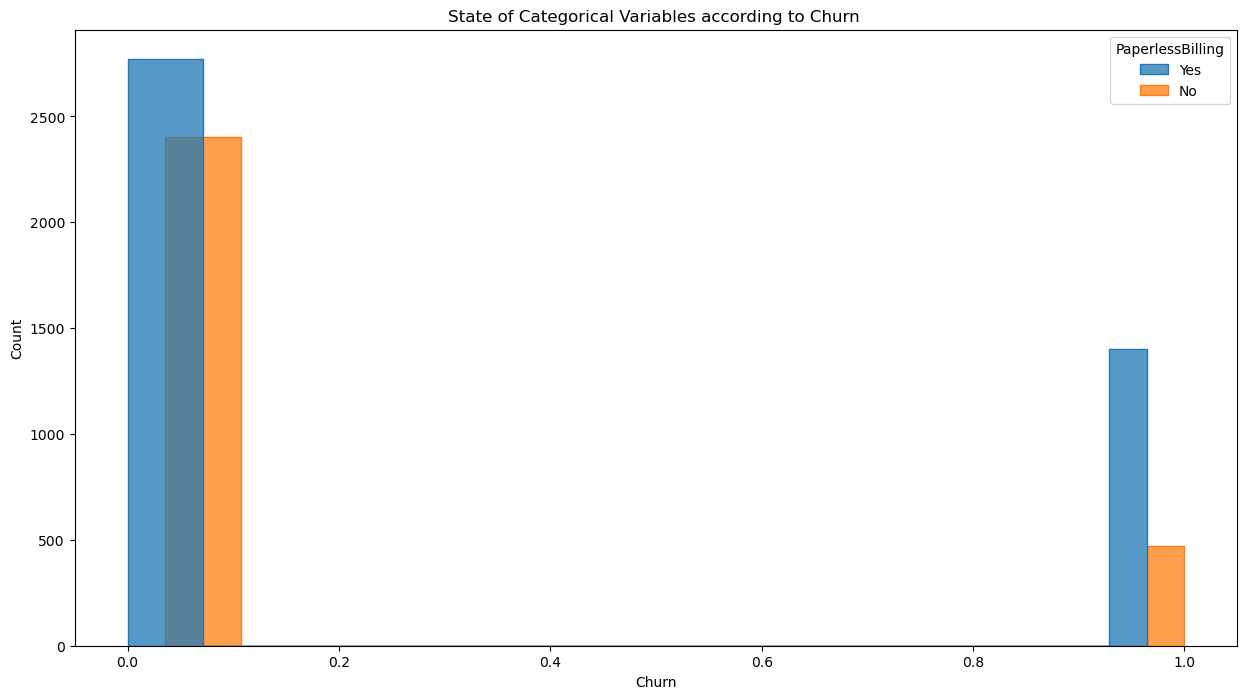

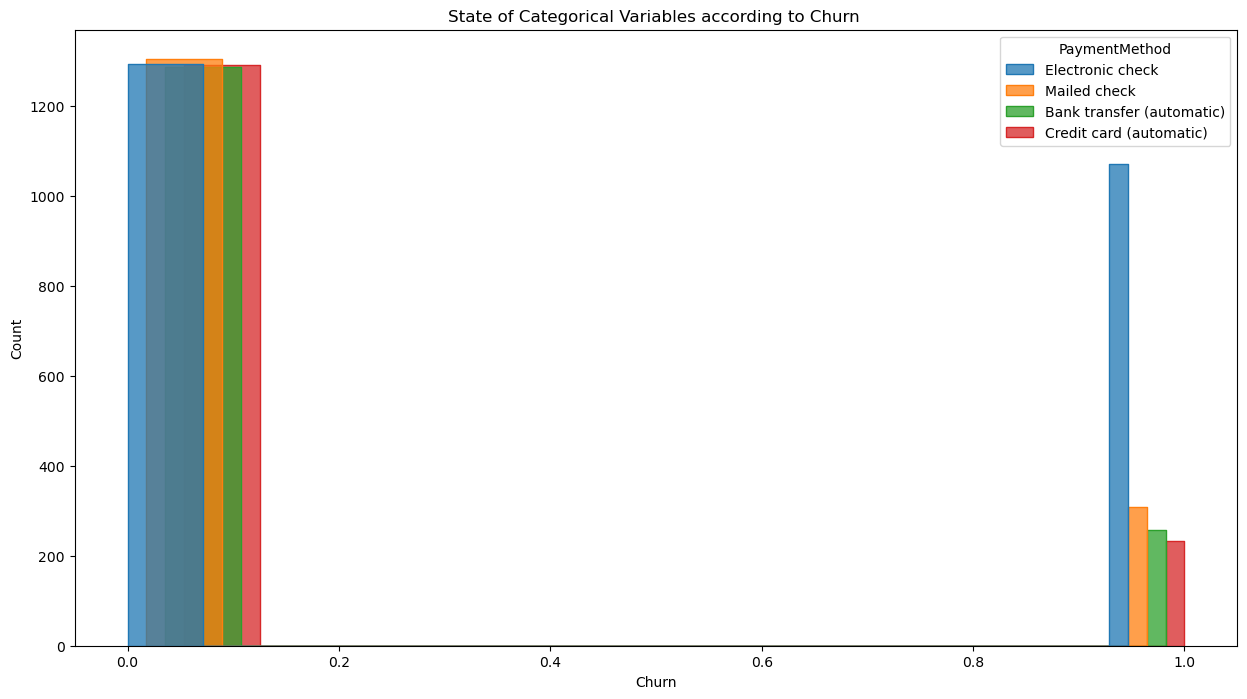

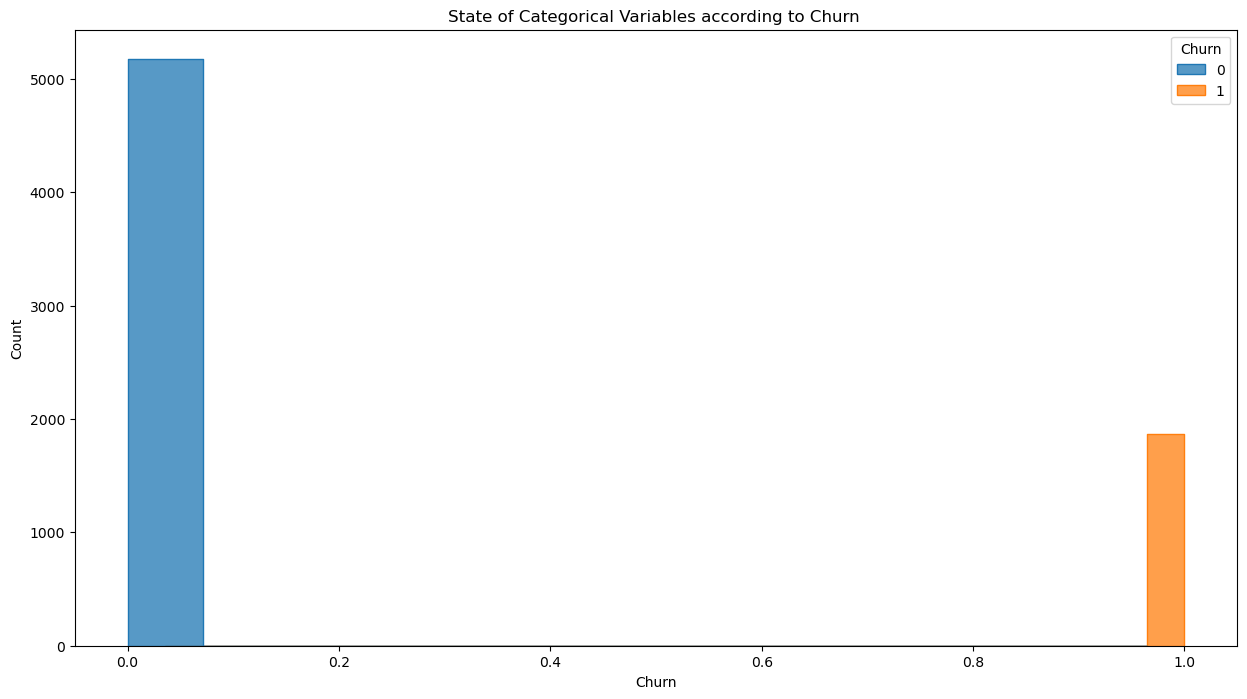

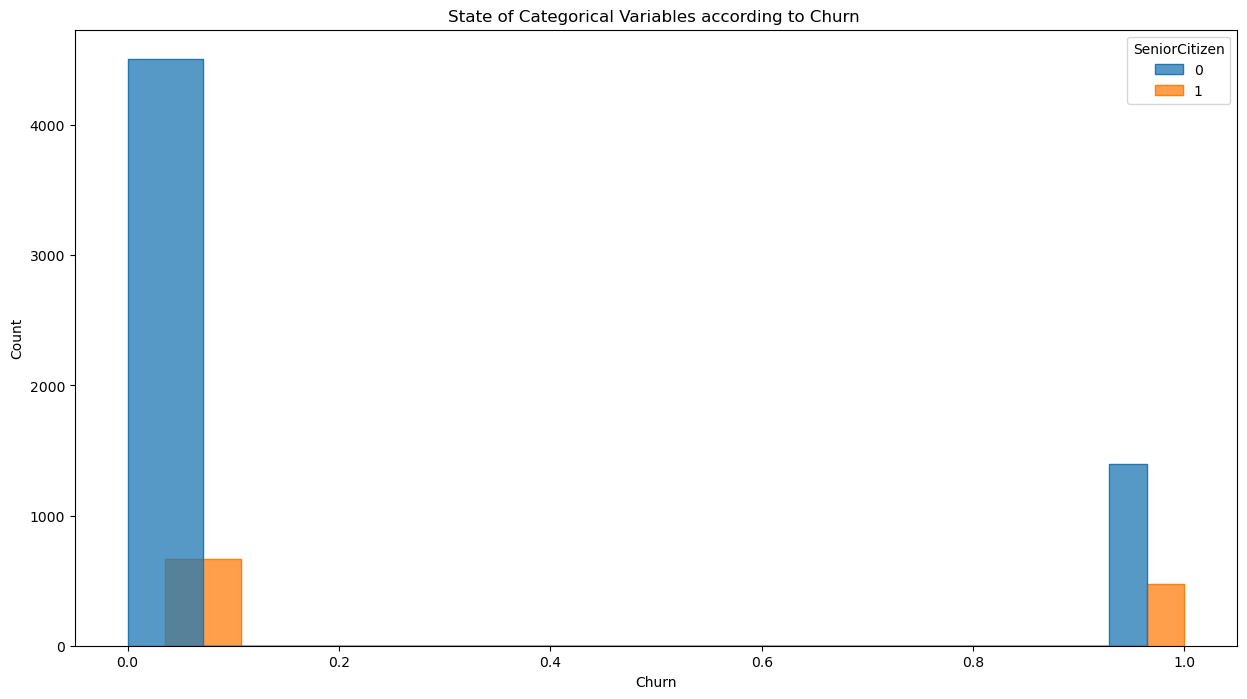

In [18]:
def target_vs_category_visual(dataframe,target, categorical_col):
    plt.figure(figsize=(15,8))
    sns.histplot(x=target,hue=categorical_col, data=dataframe,element="step",multiple="dodge")
    plt.title("State of Categorical Variables according to Churn ")
    plt.show()
    
def target_summary_with_cat(dataframe,target,categorical_col):
    print(pd.DataFrame({"CHURN_MEAN": dataframe.groupby(categorical_col)[target].mean()}))
    print(20*"-")


for col in cat_cols:
    target_vs_category_visual(df,"Churn",col)
    

### Yorumlar:

* Erkek ve kadın müşteriler için müşteri kaybı birbirine çok benzer!

* Aynı şekilde SeniorCitizens müşterilerinin sayısı da oldukça düşük! Bunun dışında, **SeniorCitizens müşterilerinde neredeyse %40'lık bir kayıp** gözlemleyebiliyoruz. 1142 SeniorCitizens müşterisinden toplam 476 müşteriye karşılık gelmektedir.

* Partner ile birlikte yaşayan müşteriler, Partner ile yaşamayanlara kıyasla **daha az kayıp** yaşadılar.

* Benzer şekilde, yanında bağımlısı(Dependents) olmayan müşteriler için de **kayıp oranı yüksek**!



* Telefon Hizmeti için, (telefon hizmeti olmamasına rağmen), hizmetleri bırakan müşteri sayısına kıyasla daha fazla müşteri elde tutuldu.


* Çoklu Hatlar durumunda, Çoklu Hatların mevcut olup olmadığı durumdaki kayıp oranı aynıdır.


* Çok sayıda müşteri internet hizmetinin sağlanmasında Fiber optik kabloların kullanılmasına karşı direnç göstermiştir. Tam tersine, yukarıdaki grafikte müşterilerin İnternet Hizmetleri için DSL kullanmayı tercih ettikleri görülüyor!


* StreamingTV ve StreamingMovies aynı grafiği görüntüler. StreamingTV ve StreamingMovies'e abone olup olmadıklarına bakılmaksızın birçok müşteri kaybedildi. 

* Müşterilere bir servisi söz konusu olduğunda, OnlineSecurity, OnlineBackup, DeviceProtection ve TechSupport hizmetleri yukarıdaki görselleştirmelerden çok önemlidir!


* Çok sayıda müşteri, yukarıda belirtilen özelliklere sahip hizmetlerin yetersiz olması durumunda servis sağlayıcısını değiştirmiştir.


* Aydan Aylık Sözleşmeye göre müşteri kaybı oldukça yüksektir. Bunun nedeni muhtemelen müşterilerin kendilerine sunulan çeşitli hizmetleri test etmeleri ve dolayısıyla paradan tasarruf etmek için 1 aylık hizmetin test edilmesidir!


* Diğer bir neden de internet hizmeti, yayın hizmeti ve telefon hizmetiyle ilgili genel deneyimin tutarlı olmaması olabilir. Her müşterinin farklı bir önceliği vardır ve bu nedenle 3 kişiden biri eşit düzeydeyse tüm hizmet kesilir!


* Kağıtsız Faturalama, çok sayıda müşterinin dağıldığını gösteriyor. Bunun nedeni muhtemelen bazı ödeme sorunları veya makbuz sorunlarıdır.


* Müşteriler Elektronik çek Ödeme Yöntemine açıkça kızdılar. Elektronik çek kullanılarak ödenen 2365 adet faturadan şaşırtıcı bir şekilde 1071 müşteri bu ödeme yöntemi sayesinde hizmet havuzundan çıktı. Şirketin kesinlikle düşmesi gerekiyor


* Elektronik çek yöntemini veya sorunsuz ve kullanıcı dostu hale getirin.

## Kategorik Değişkenlerin Churn Ortalaması

In [19]:
for col in cat_cols:
    target_summary_with_cat(df,"Churn",col)

        CHURN_MEAN
gender            
Female       0.269
Male         0.262
--------------------
         CHURN_MEAN
Partner            
No            0.330
Yes           0.197
--------------------
            CHURN_MEAN
Dependents            
No               0.313
Yes              0.155
--------------------
              CHURN_MEAN
PhoneService            
No                 0.249
Yes                0.267
--------------------
                  CHURN_MEAN
MultipleLines               
No                     0.250
No phone service       0.249
Yes                    0.286
--------------------
                 CHURN_MEAN
InternetService            
DSL                   0.190
Fiber optic           0.419
No                    0.074
--------------------
                     CHURN_MEAN
OnlineSecurity                 
No                        0.418
No internet service       0.074
Yes                       0.146
--------------------
                     CHURN_MEAN
OnlineBackup                

## Group 1 : Customer Information :
gender | SeniorCitizen | Partner | Dependents

In [20]:
gender = df[df['Churn'] == 1]['gender'].value_counts()
gender = [gender[0] / sum(gender) * 100, gender[1] / sum(gender) * 100] # Female / Male

seniorcitizen = df[df['Churn'] == 1]['SeniorCitizen'].value_counts()
seniorcitizen = [seniorcitizen[0] / sum(seniorcitizen) * 100,seniorcitizen[1] / sum(seniorcitizen) * 100] # No - Yes

partner = df[df['Churn'] == 1]['Partner'].value_counts()
partner = [partner[0] / sum(partner) * 100,partner[1] / sum(partner) * 100] # No - Yes

dependents = df[df['Churn'] == 1]['Dependents'].value_counts()
dependents = [dependents[0] / sum(dependents) * 100,dependents[1] / sum(dependents) * 100] # No - Yes

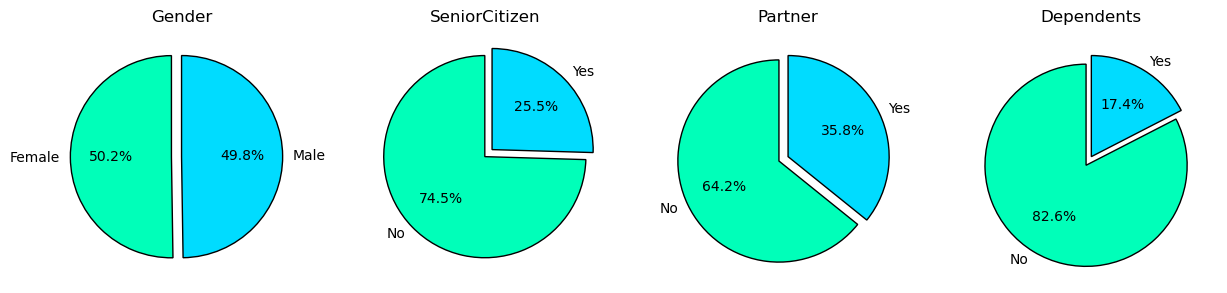

In [21]:
ax,fig = plt.subplots(nrows = 1,ncols = 4,figsize = (15,15))

plt.subplot(1,4,1)
plt.pie(gender,labels = ['Female','Male'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Gender');

plt.subplot(1,4,2)
plt.pie(seniorcitizen,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('SeniorCitizen');

plt.subplot(1,4,3)
plt.pie(partner,labels = ['No','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Partner');

plt.subplot(1,4,4)
plt.pie(dependents,labels = ['No','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Dependents');

### Yorum

Hizmet değiştiren kadın ve erkek müşteriler arasında %50 - %50 oranında net bir ayrım gözlemliyoruz.
Bu nedenle, geçişin nedeni hizmetle veya müşterilerin kötü tepki verdiği bir süreçle ilgili bir şeydir!

Kaybolan müşterilerin %75'i SeniorCitizens(Kıdemli Vatandaş) değil! Bu, şirketin dikkatini başka yöne çekmesi gereken önemli bir bilgidir!

Tek başına yaşayan müşteriler hizmetleri kesmiş durumda. Partners & Dependents verilerine göre, ortaya çıkan müşterilerin ortalama %73,4'ü tek başına yaşıyordu.

## Group 2: Services Subscribed by the Customer :
PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies |

In [22]:
phoneservice = df[df['Churn'] == 1]['PhoneService'].value_counts()
phoneservice = [phoneservice[0] / sum(phoneservice) * 100, phoneservice[1] / sum(phoneservice) * 100] # No - Yes

multiplelines = df[df['Churn'] == 1]['MultipleLines'].value_counts()
multiplelines = [multiplelines[0] / sum(multiplelines) * 100,multiplelines[1] / sum(multiplelines) * 100, multiplelines[2] / sum(multiplelines) * 100] # No - No Phone Service - Yes 

internetservice = df[df['Churn'] == 1]['InternetService'].value_counts()
internetservice = [internetservice[0] / sum(internetservice) * 100,internetservice[1] / sum(internetservice) * 100, internetservice[2] / sum(internetservice) * 100] # DSL - Fiber Optic - No 

streamingtv = df[df['Churn'] == 1]['StreamingTV'].value_counts()
streamingtv = [streamingtv[0] / sum(streamingtv) * 100,streamingtv[1] / sum(streamingtv) * 100, streamingtv[2] / sum(streamingtv) * 100] # No - No Internet Service - Yes 

streamingmovies = df[df['Churn'] == 1]['StreamingMovies'].value_counts()
streamingmovies = [streamingmovies[0] / sum(streamingmovies) * 100,streamingmovies[1] / sum(streamingmovies) * 100, streamingmovies[2] / sum(streamingmovies) * 100] # No - No Internet Service - Yes 

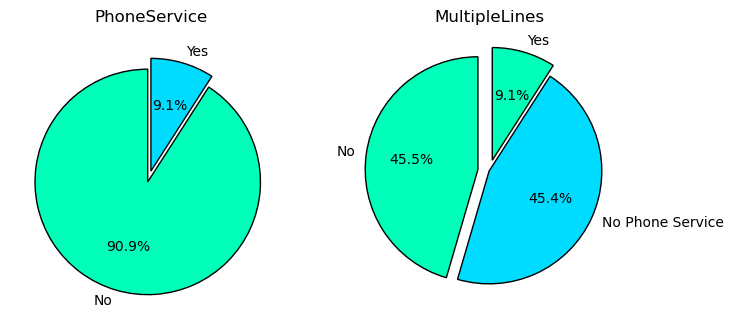

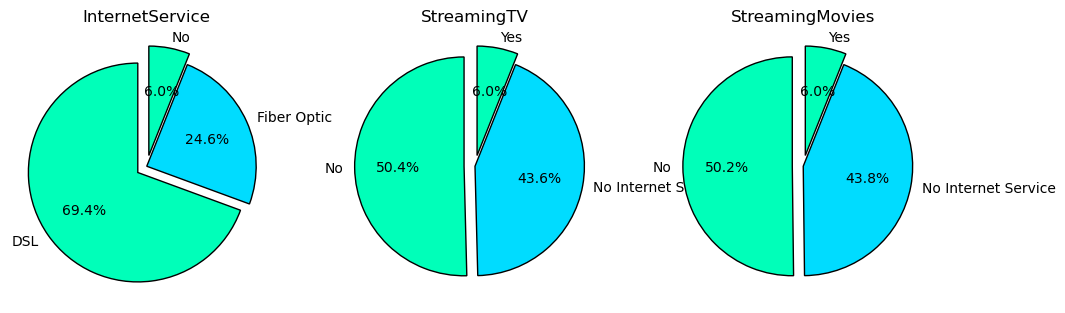

In [23]:
ax,fig = plt.subplots(nrows = 1,ncols = 2,figsize = (8,8))

plt.subplot(1,2,1)
plt.pie(phoneservice,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PhoneService');

plt.subplot(1,2,2)
plt.pie(multiplelines,labels = ['No','No Phone Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('MultipleLines');

ax,fig = plt.subplots(nrows = 1,ncols = 3,figsize = (12,12))

plt.subplot(1,3,1)
plt.pie(internetservice,labels = ['DSL', 'Fiber Optic','No'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('InternetService');

plt.subplot(1,3,2)
plt.pie(streamingtv,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('StreamingTV');

plt.subplot(1,3,3)
plt.pie(streamingmovies,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('StreamingMovies');


* Telefon Hizmeti sağlamasına rağmen müşterilerin büyük bir yüzdesi telefon hizmetini değiştirdi!

* Benzer şekilde, müşteri aboneliği iptali ne olursa olsun gerçekleştirildiğinden MultipleLines'ın kullanılabilirliği de önemli değildi!

* Müşteriler, Fiber Optik kabloların InternetService'i hizmetlerden %70'lik kesin bir vazgeçme oranıyla sağlama yaklaşımını kesinlikle takdir etmediler!

* StreamingTV ve StreamingMovies için bu hizmetlere sahip olmayan müşteriler aboneliklerini kesinlikle iptal etti, ancak müşterilerin ortalama %43,7'si akış içeriğini tüketmelerine rağmen aboneliklerini değiştirdi.

## Group 2: Services Subscribed by the Customer
OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport 


In [24]:
onlinesecurity = df[df['Churn'] == 1]['OnlineSecurity'].value_counts()
onlinesecurity = [onlinesecurity[0] / sum(onlinesecurity) * 100,onlinesecurity[1] / sum(onlinesecurity) * 100, onlinesecurity[2] / sum(onlinesecurity) * 100] # No - No Internet Service - Yes 

onlinebackup = df[df['Churn'] == 1]['OnlineBackup'].value_counts()
onlinebackup = [onlinebackup[0] / sum(onlinebackup) * 100,onlinebackup[1] / sum(onlinebackup) * 100, onlinebackup[2] / sum(onlinebackup) * 100] # No - No Internet Service - Yes 

deviceprotection = df[df['Churn'] == 1]['DeviceProtection'].value_counts()
deviceprotection = [deviceprotection[0] / sum(deviceprotection) * 100,deviceprotection[1] / sum(deviceprotection) * 100, deviceprotection[2] / sum(deviceprotection) * 100] # No - No Internet Service - Yes 

techsupport = df[df['Churn'] == 1]['TechSupport'].value_counts()
techsupport = [techsupport[0] / sum(techsupport) * 100,techsupport[1] / sum(techsupport) * 100, techsupport[2] / sum(techsupport) * 100] # No - No Internet Service - Yes 

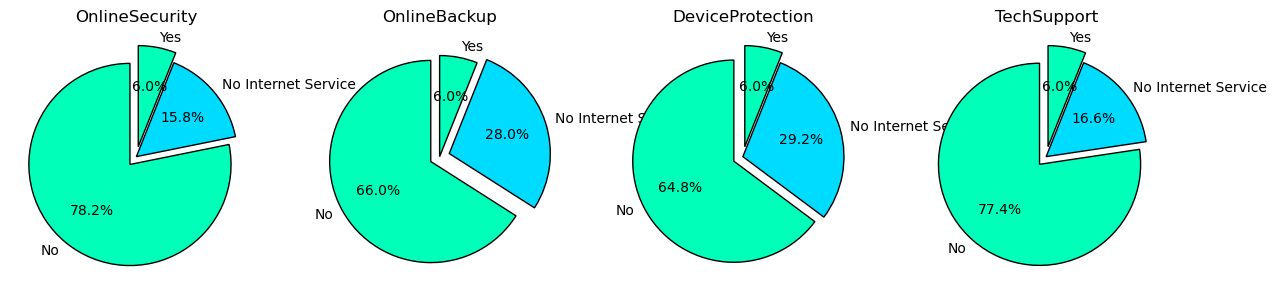

In [25]:
ax,fig = plt.subplots(nrows = 1,ncols = 4,figsize = (15,15))

plt.subplot(1,4,1)
plt.pie(onlinesecurity,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('OnlineSecurity');

plt.subplot(1,4,2)
plt.pie(onlinebackup,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('OnlineBackup');

plt.subplot(1,4,3)
plt.pie(deviceprotection,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('DeviceProtection');

plt.subplot(1,4,4)
plt.pie(techsupport,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('TechSupport');

Yukarıdaki pasta grafikleri OnlineSecurity, OnlineBackup, DeviceProtection & TechSupport sağlamanın önemini vurguluyor, çünkü müşterilerin ortalama %71,6'sı bu özelliklerin eksikliği nedeniyle hizmetlerini kesiyor!

## Group 3 : Contract | PaperlessBilling | PaymentMethod |

In [26]:
contract = df[df['Churn'] == 1]['Contract'].value_counts()
contract = [contract[0] / sum(contract) * 100, contract[1] / sum(contract) * 100, contract[2] / sum(contract) * 100] # Month-to-month - One year - Two year

paperlessbilling = df[df['Churn'] == 1]['PaperlessBilling'].value_counts()
paperlessbilling = [paperlessbilling[0] / sum(paperlessbilling) * 100,paperlessbilling[1] / sum(paperlessbilling) * 100] # No - Yes 

paymentmethod = df[df['Churn'] == 1]['PaymentMethod'].value_counts()
paymentmethod = [paymentmethod[0] / sum(paymentmethod) * 100, paymentmethod[1] / sum(paymentmethod) * 100, 
            paymentmethod[2] / sum(paymentmethod) * 100, paymentmethod[3] / sum(paymentmethod) * 100] 

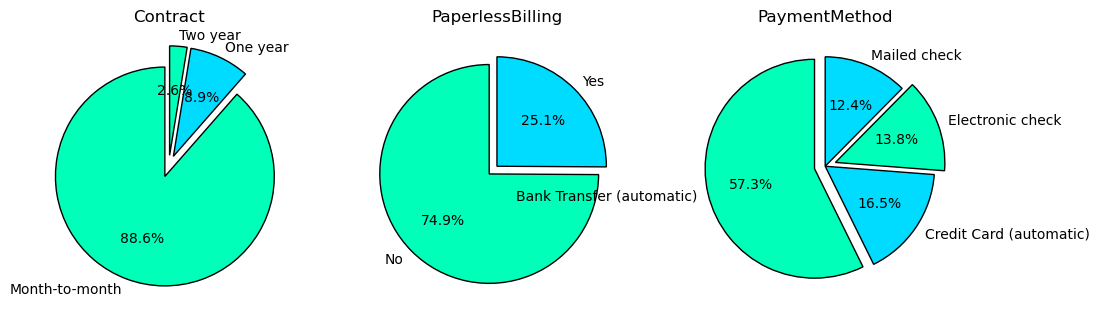

In [27]:
ax,fig = plt.subplots(nrows = 1,ncols = 3,figsize = (12,12))

plt.subplot(1,3,1)
plt.pie(contract,labels = ['Month-to-month','One year','Two year'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0.1,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Contract');

plt.subplot(1,3,2)
plt.pie(paperlessbilling,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PaperlessBilling');

plt.subplot(1,3,3)
plt.pie(paymentmethod,labels = ['Bank Transfer (automatic)','Credit Card (automatic)','Electronic check','Mailed check'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PaymentMethod');

### Yorum

* Aydan Aya Sözleşme süresi, %88,6'lık devasa bir müşteri kaybı söz konusu olduğunda baskın paya sahip!

* Kağıtsız Faturalandırma müşteriler tarafından beğenilmiyor gibi görünüyor!

* Elektronik çek, kaybın %57,3'ünü oluşturduğu için mutlaka ayıklanması gerekiyor. Bunu Postayla Çek, Banka Havalesi (otomatik) ve Kredi Kartı (otomatik) takip eder!

### Numerik Değişkenler vs Hedef Değişken(Churn)

In [28]:
def target_summary_with_num(dataframe,target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col:"mean"}), end="\n\n")
    print("###################################")
    

for col in num_cols:
    target_summary_with_num(df,"Churn",col)

       tenure
Churn        
0      37.570
1      17.979

###################################
       MonthlyCharges
Churn                
0              61.265
1              74.441

###################################
       TotalCharges
Churn              
0          2549.911
1          1531.796

###################################


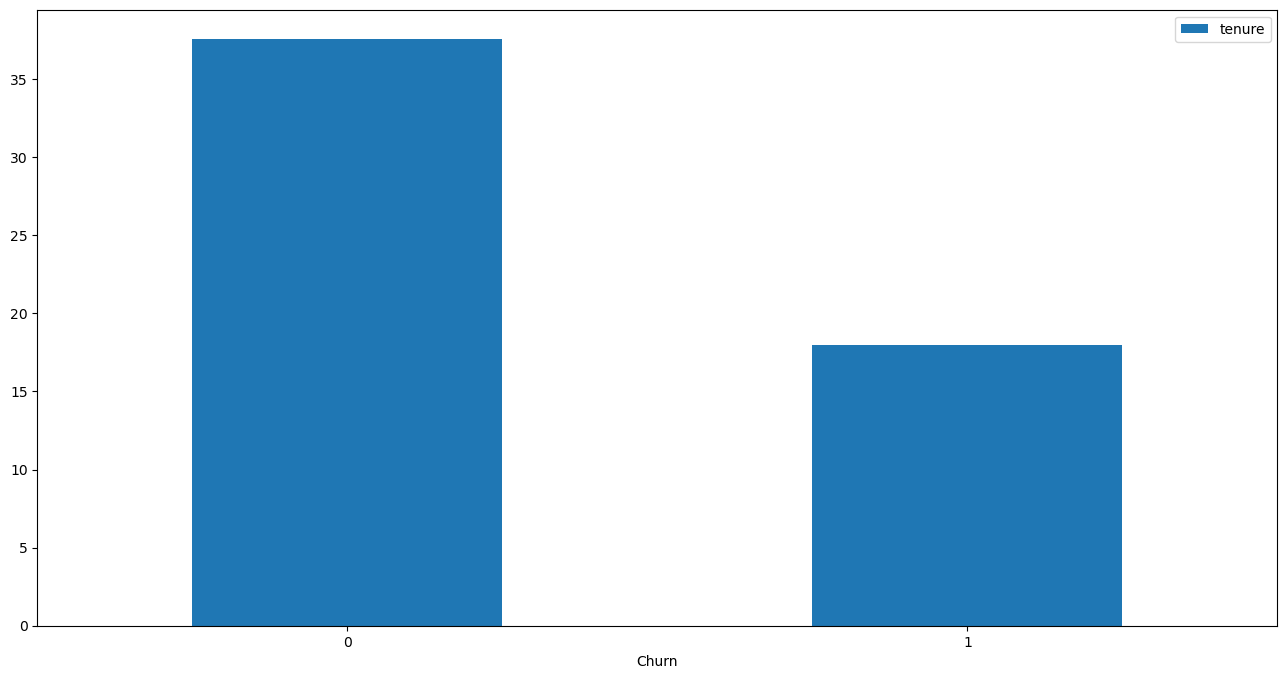

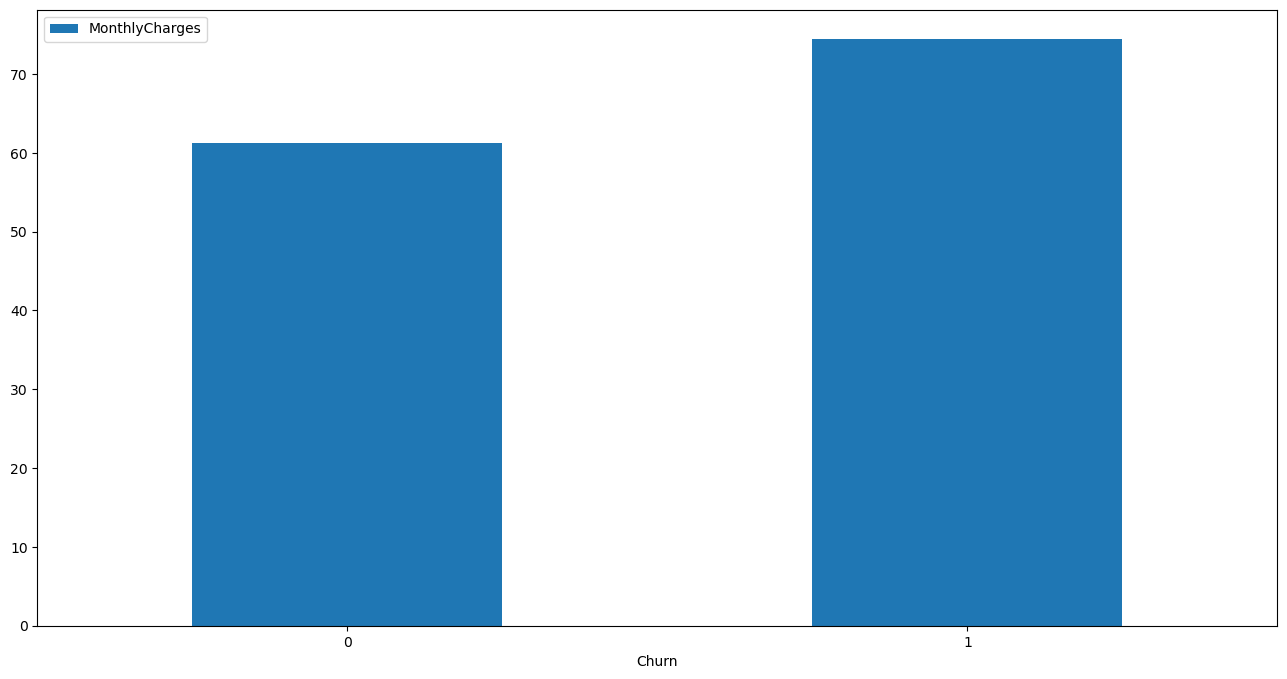

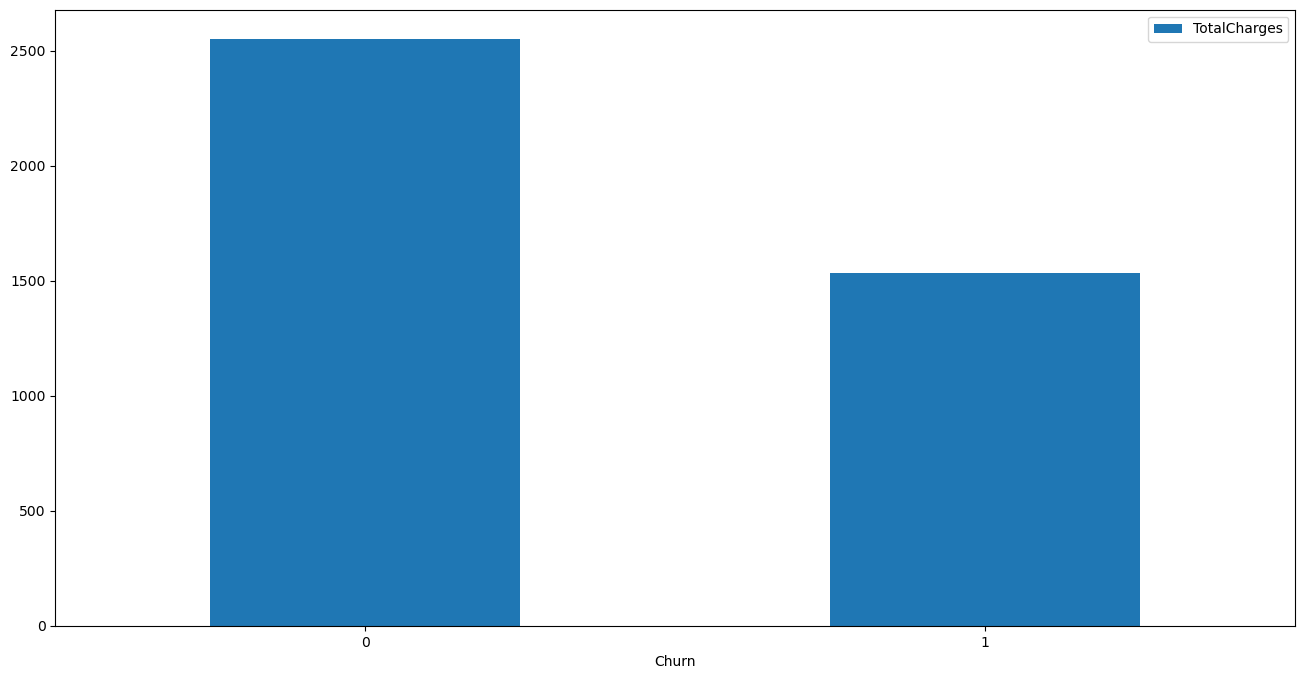

In [29]:
for col in num_cols:
    df.groupby('Churn').agg({col:'mean'}).plot(kind='bar', rot = 0,figsize=(16,8))

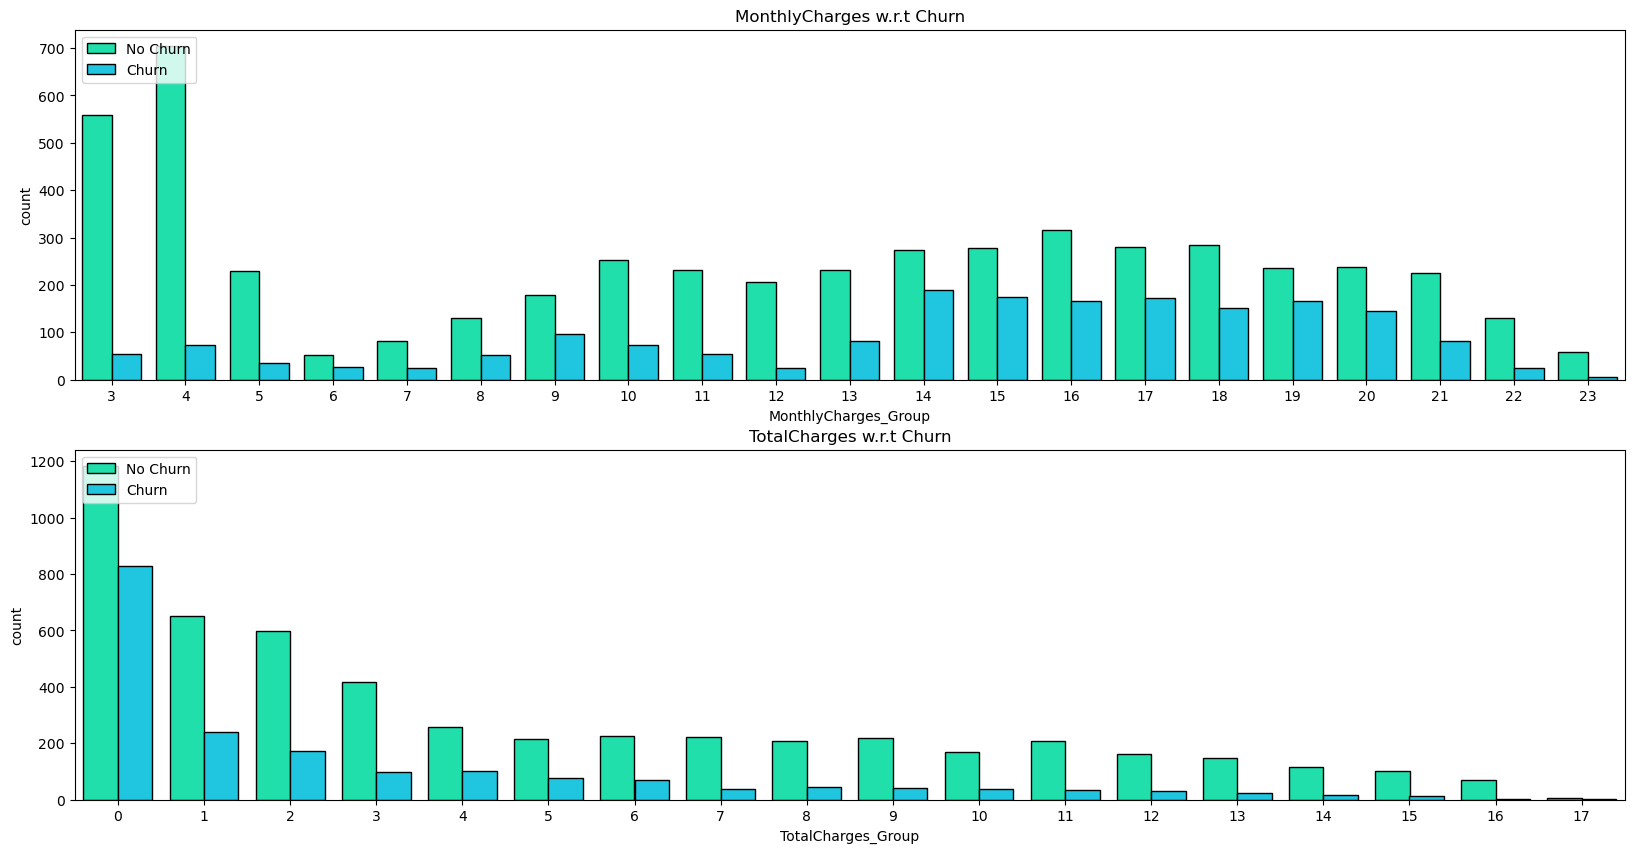

In [32]:
df['MonthlyCharges_Group'] = [int(i / 5) for i in df['MonthlyCharges']]
df['TotalCharges_Group'] = [int(i / 500) for i in df['TotalCharges']]

fig, ax = plt.subplots(nrows = 2,ncols = 1,figsize = (20,10))
for i in range(len(num_cols[1:])):
    plt.subplot(2,1,i+1)
    sns.countplot(x = num_cols[1 + i]+'_Group',data = df,hue = "Churn",palette = colors,edgecolor = 'black')
    plt.legend(['No Churn','Churn'],loc = 'upper left')
    title = num_cols[1 + i] + ' w.r.t Churn'
    plt.title(title)

### Yorum

* MonthlyCharges grubu için 65 (13x5) - 105 (21x5) arası değerlerde kayıp oranı yüksektir. Bu MonthlyCharges değer aralığı müşterilerin geçiş yapmasına neden oldu.

* Çok yüksek sayıda müşteri, 500'ün altındaki TotalCharges için hizmetlerden vazgeçti

## Hedef Değişkene (Churn) göre Numerik Değişkenler ve Kategorik Değişkenler

In [33]:
l1 = ['gender','SeniorCitizen','Partner','Dependents'] # Customer Information
l2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] # Services Signed Up for!
l3 = ['Contract','PaperlessBilling','PaymentMethod'] # Payment Information

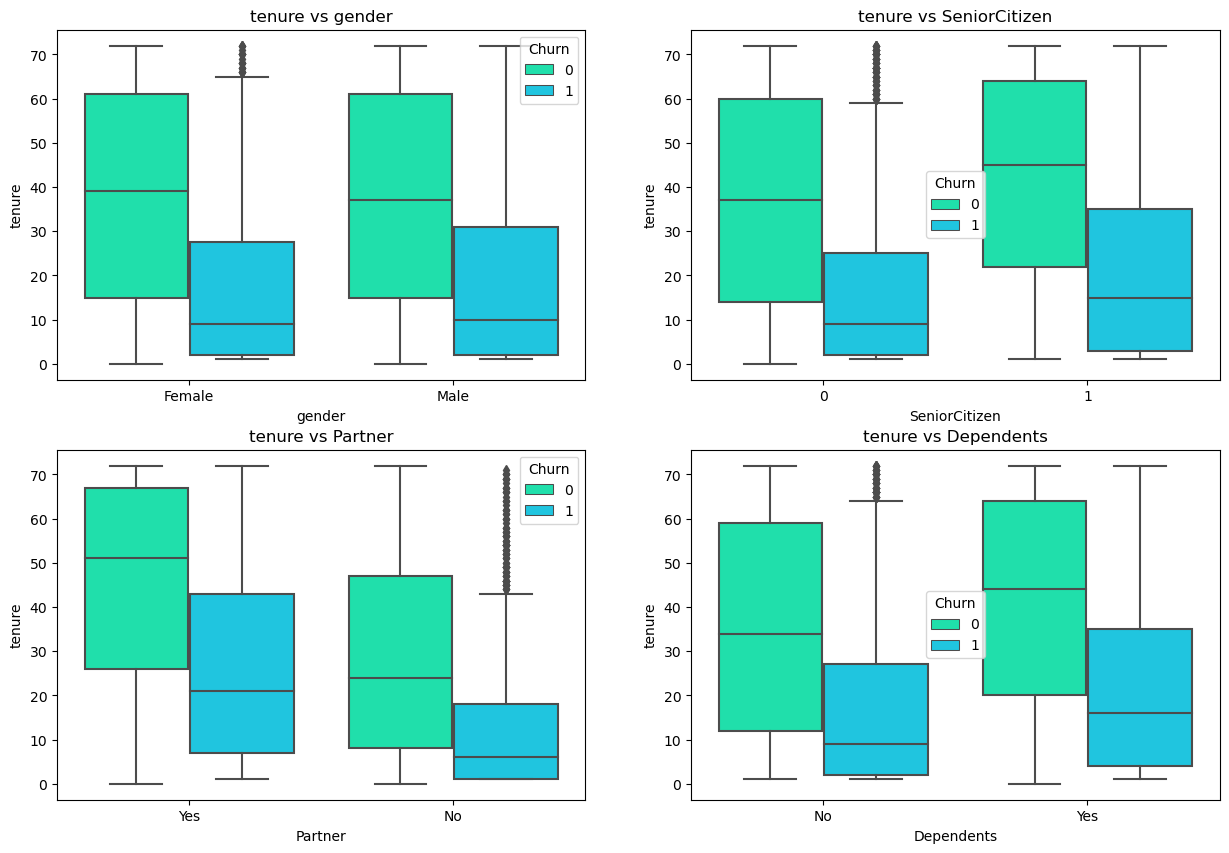

In [34]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = l1[i],y = 'tenure',data = df,hue = 'Churn',palette = colors);
    plt.title('tenure vs ' + l1[i])

## Yorumlar

* Erkek ve Kadın müşteri kaybı grafikleri birbirine çok benzer.

* SeniorCitizen, 0 - 35 ay arası kullanım süresi değerleri için hizmetlerden vazgeçmiştir. 20 - 35 ay, SeniorCitizen devam etme veya geçiş yapma konusunda bir tür karar verme dönemidir.

* Benzer şekilde iş ortakları olan müşteriler de hizmeti 5 ila 45 ay süreyle kullanmaya devam etti.

### tenure vs Group 2: Services Subscribed by the Customer : PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies 

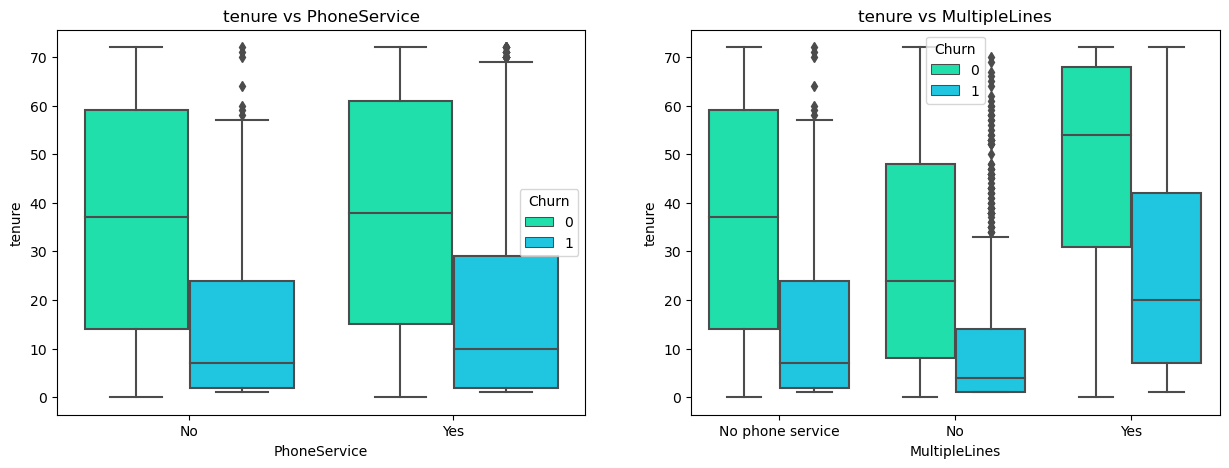

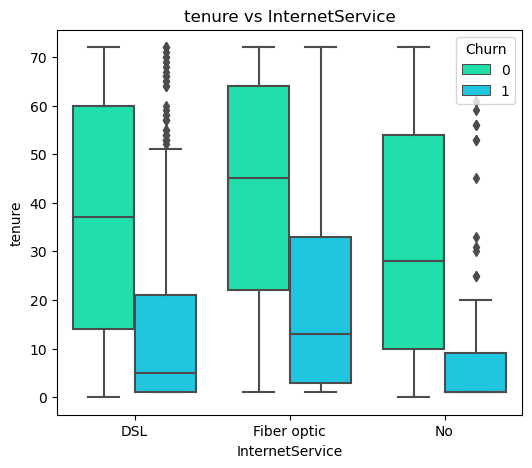

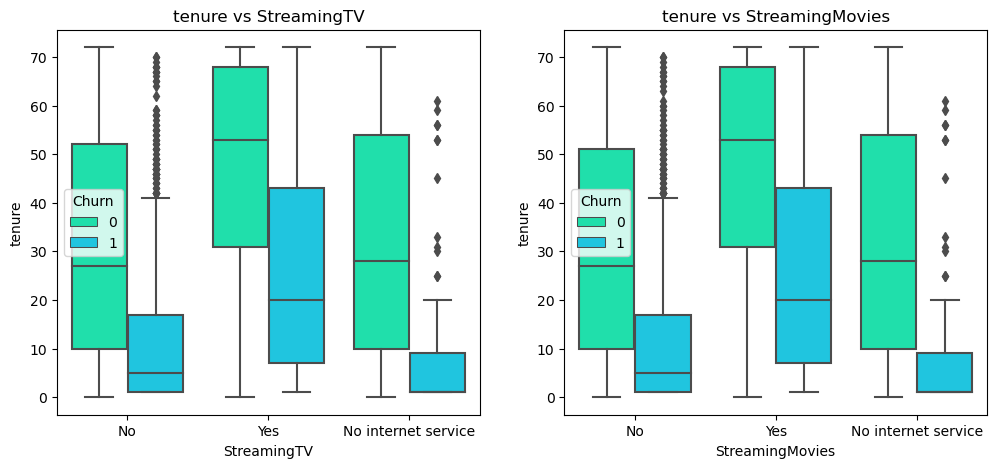

In [36]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i],y = 'tenure',data = df,hue = 'Churn',palette = colors);
    plt.title('tenure vs ' + l2[i])

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = l2[2],y = 'tenure',data = df,hue = 'Churn',palette = colors);
plt.title('tenure vs ' + l2[2])
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i + 3],y = 'tenure',data = df,hue = 'Churn',palette = colors)
    plt.title('tenure vs ' + l2[i + 3])

### Yorumlar

* MutipleLines'ın varlığı, müşterilerin hizmetlerden vazgeçip vazgeçmemesine bakılmaksızın ortalama Aylık Ücretleri zorlar.

* Kullanım süresi ve PhoneService grafiği için, PhoneService'in kullanılabilirliği veya yansıtılmaması görselleri. Müşteriler muhtemelen yoğun telefon (arama - mesaj) kullanıcısı değildi.

* InternetService için, karışıklık yaklaşık 30 - 35 ay sürdüğü için müşteriler Fiber Optik kabloların kullanımı konusunda oldukça şüpheci görünüyorlar, ardından kabloyu ileriye taşımadan ya da yeni bir kabloya geçmeden önce!

* StreamingTV ve StreamingMovies'e benzer şekilde, yaklaşık 10 - 40 aylık bir kullanım dışı kalma süresi gözlemlenebilir!

### tenure vs Group 2: Services Subscribed by the Customer : OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport


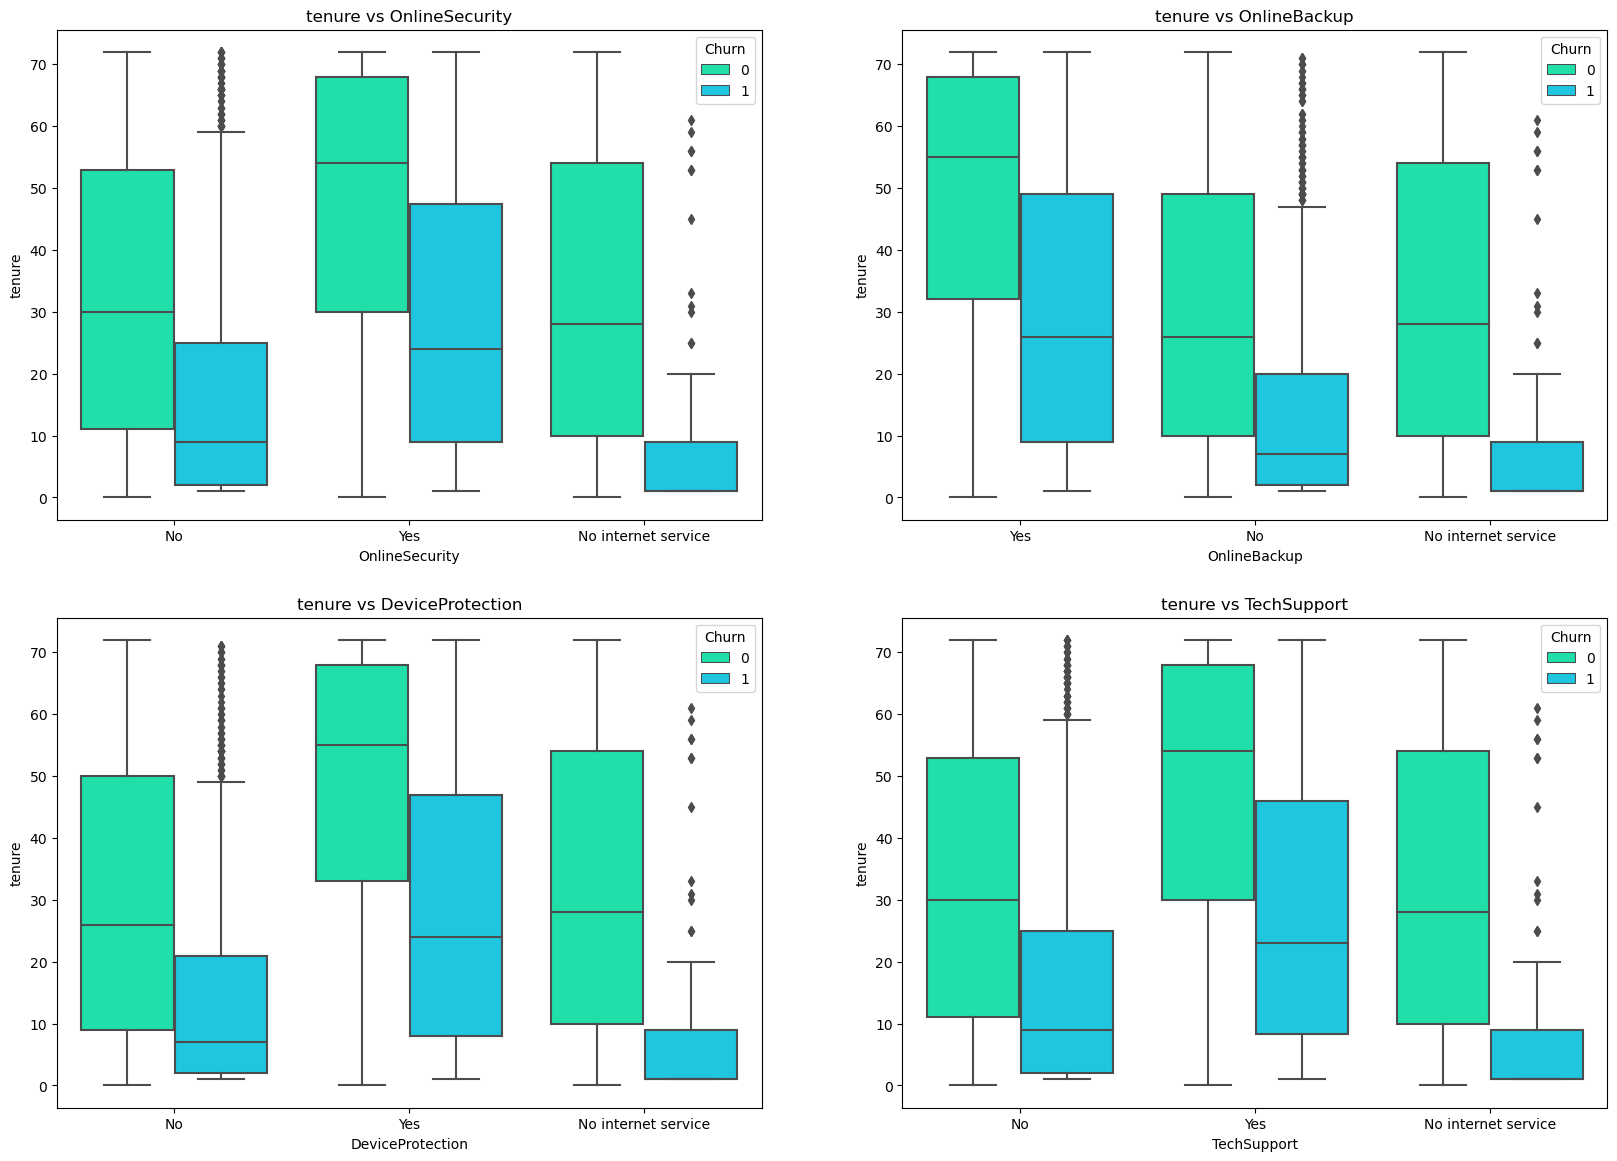

In [37]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = l2[i - 4],y = 'tenure',data = df,hue = 'Churn',palette = colors)
    plt.title('tenure vs ' + l2[i-4])

### Yorumlar

OnlineSecurity, OnlineBackup, DeviceProtection ve TechSupport için ortalama kayıp kullanım süresi değeri 25 aydır. Bu kayıp süresinin en yüksek değeri yaklaşık 45 aydır.

30 - 35 aylık dönem, müşterilerin mevcut hizmetlere devam mı edecekleri yoksa yukarıdaki özelliklere mi geçecekleri konusunda bir telefon görüşmesi yaptıkları dönemdir!

## tenure vs Group 3 : Contract | PaperlessBilling | PaymentMethod |¶


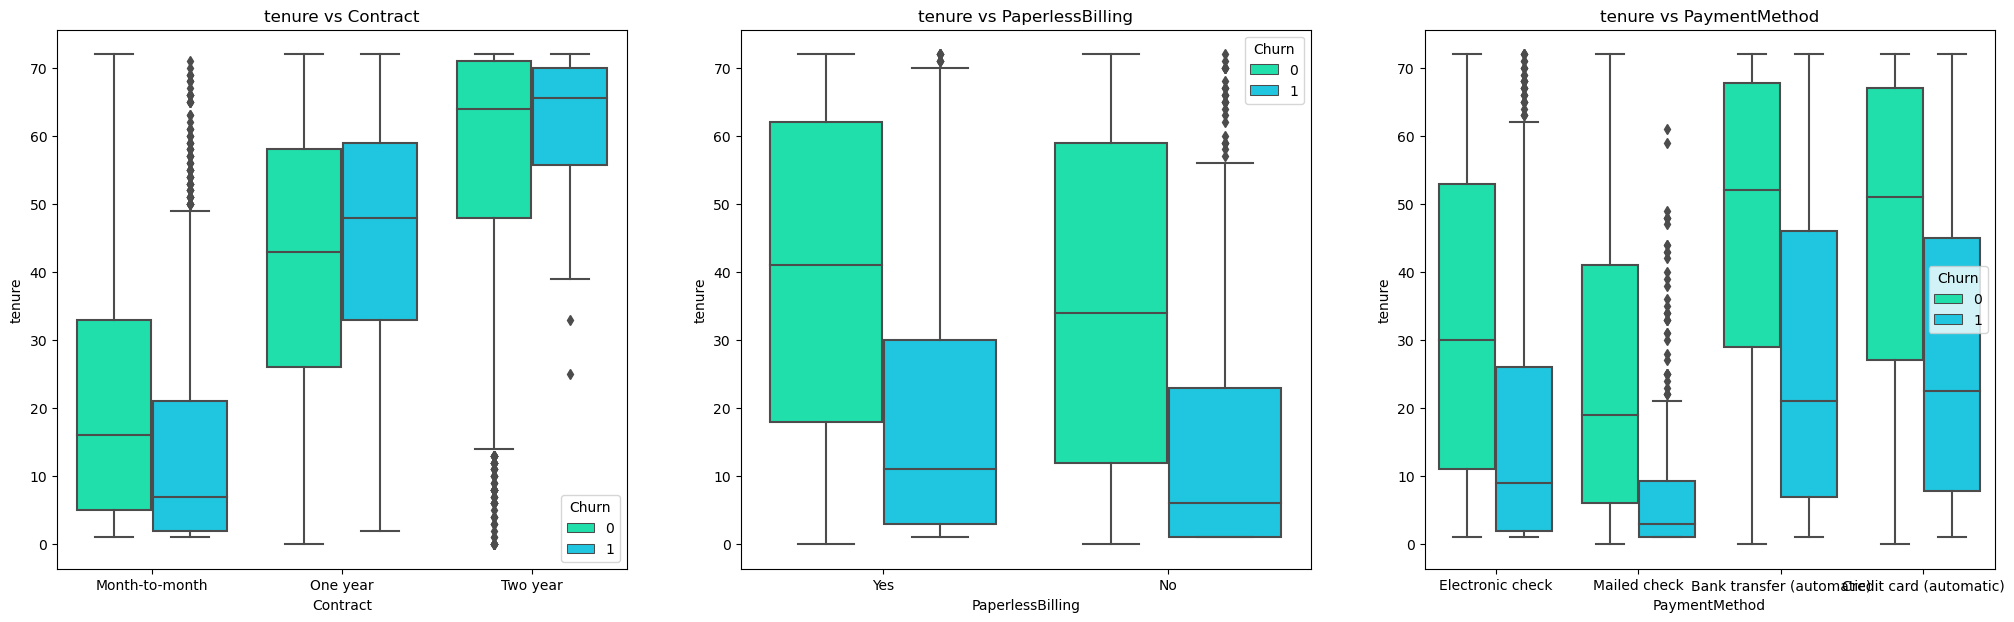

In [38]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
for i in range(len(l3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = l3[i],y = 'tenure',data = df,hue = 'Churn',palette = colors)
    plt.title('tenure vs ' + l3[i])

### Yorumlar

* Müşteriler hizmetler için Bir yıllık ve İki yıllık sözleşmeler imzaladıklarında, hizmetleri sırasıyla yaklaşık 25 ve 45 ay boyunca devam ettirecek gibi görünüyorlar! Ancak hizmetleri sorgulamaya başlıyorlar ve sırasıyla 35 ay ve 55 ay sınırından geçiş yapmayı düşünüyorlar!

* Kağıtsız Faturalandırmadan bağımsız olarak müşteriler 1. aydan itibaren geçiş yapmayı düşünüyor.

* Ödeme Yöntemi söz konusu olduğunda, Banka Havalesi (otomatik) ve Kredi Kartının (otomatik) ortalama kayıp vadesi, 20 ayın üzerinde, Elektronik çek ve Posta çekinin neredeyse iki katıdır (sırasıyla yaklaşık 10 ay ve yaklaşık 5 ay).

## MonthlyCharges vs Group 1 : Customer Information : gender | SeniorCitizen | Partner | Dependents


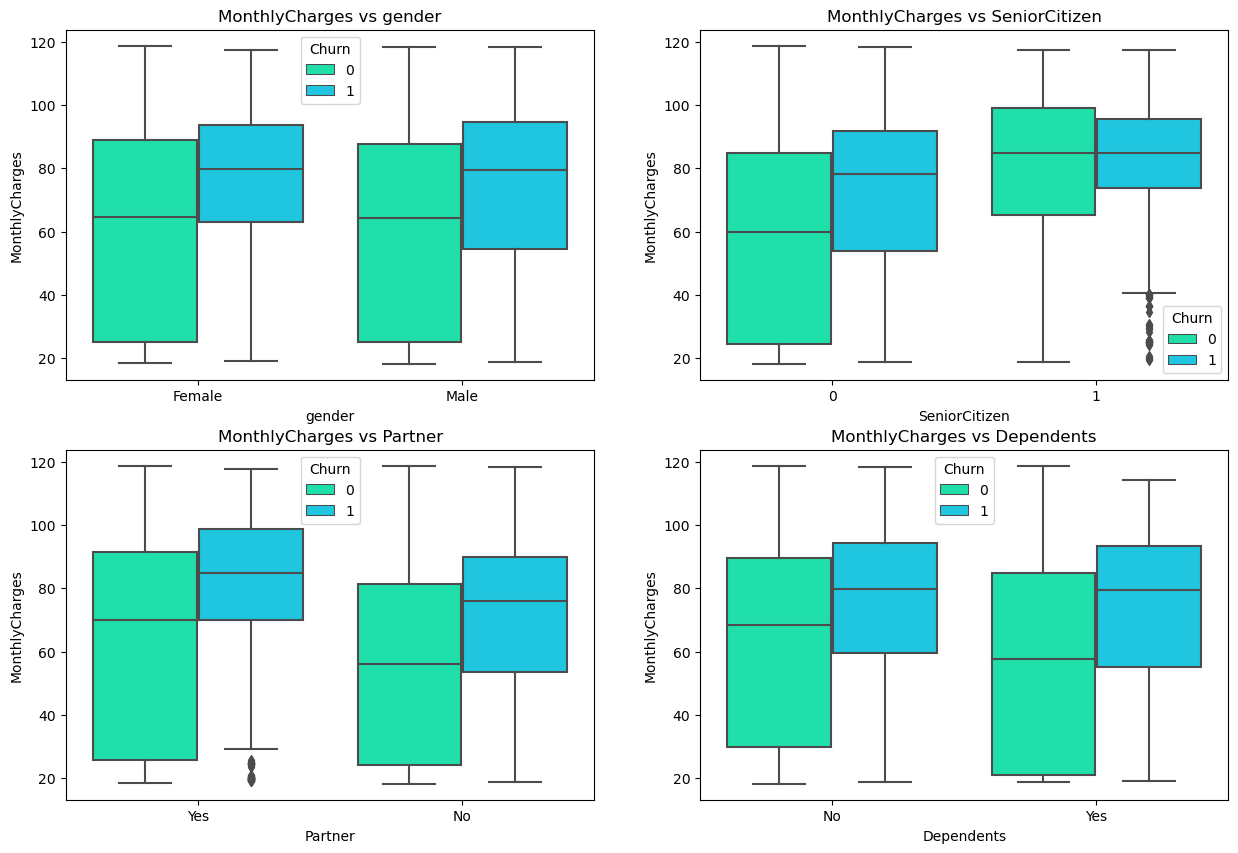

In [39]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = l1[i],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors)
    plt.title('MonthlyCharges vs ' + l1[i])

### Yorumlar


* Yukarıda belirtilen tüm özellikler için, kaybetmeyen müşterilerin medyan değeri, kaybetmeyen müşterilerin alt sınırına çok yakındır.

* Erkek ve Kadın müşterilerin ortalama Aylık Ücretleri 60 civarındadır. Kıdemli Vatandaşlar için bu değer 80'e çıkarılmıştır.

* Partner ile birlikte yaşayan müşterilerin, tek başına yaşayanlara göre daha yüksek bir alt abone kaybı limiti (MontlyCharges) 70'tir; MonthlyCharges 60'ın biraz altındadır!

### MonthlyCharges vs Group 2: Services Subscribed by the Customer : PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies


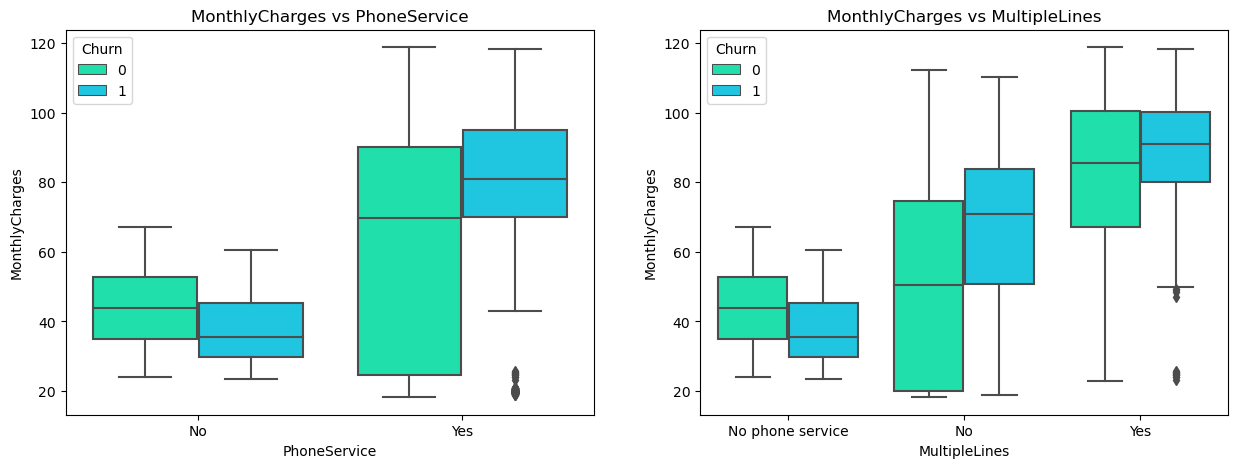

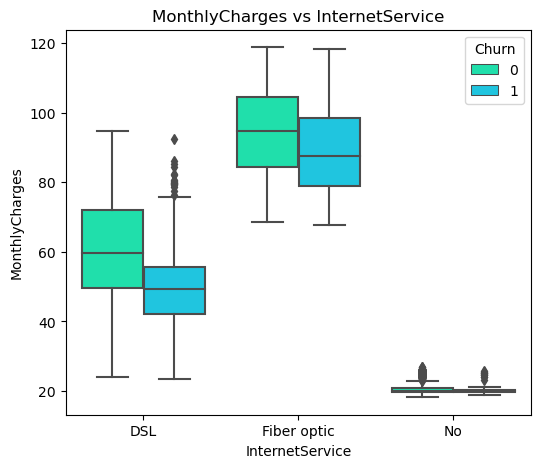

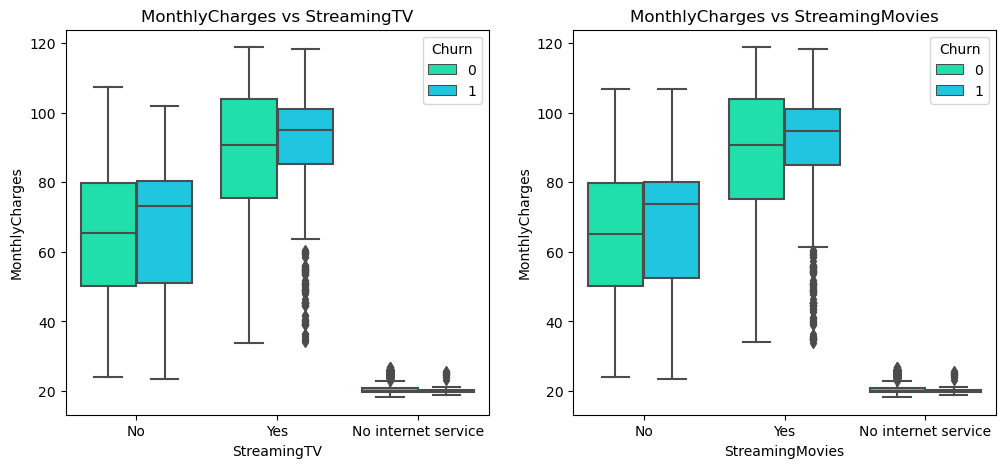

In [40]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors)
    plt.title('MonthlyCharges vs ' + l2[i])

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = l2[2],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors)
plt.title('MonthlyCharges vs ' + l2[2])
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i + 3],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors)
    plt.title('MonthlyCharges vs ' + l2[i + 3])

## Yorumlar

* Fiber Optik kabloların aylık ücretleri çok yüksektir. Bu kadar yüksek müşteri kaybının nedeni bu olabilir.

* Benzer şekilde StreamingTV ve StreamingMovies'in Aylık Ücretleri de oldukça yüksektir.

* PhoneService için MonthlyCharges aralığı 25 - 85 arasındadır ancak müşteriler MonthlyCharges'ın 75 değerinden abonelikten çıkmayı düşünürler.

## MonthlyCharges vs Group 2: Services Subscribed by the Customer : OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport


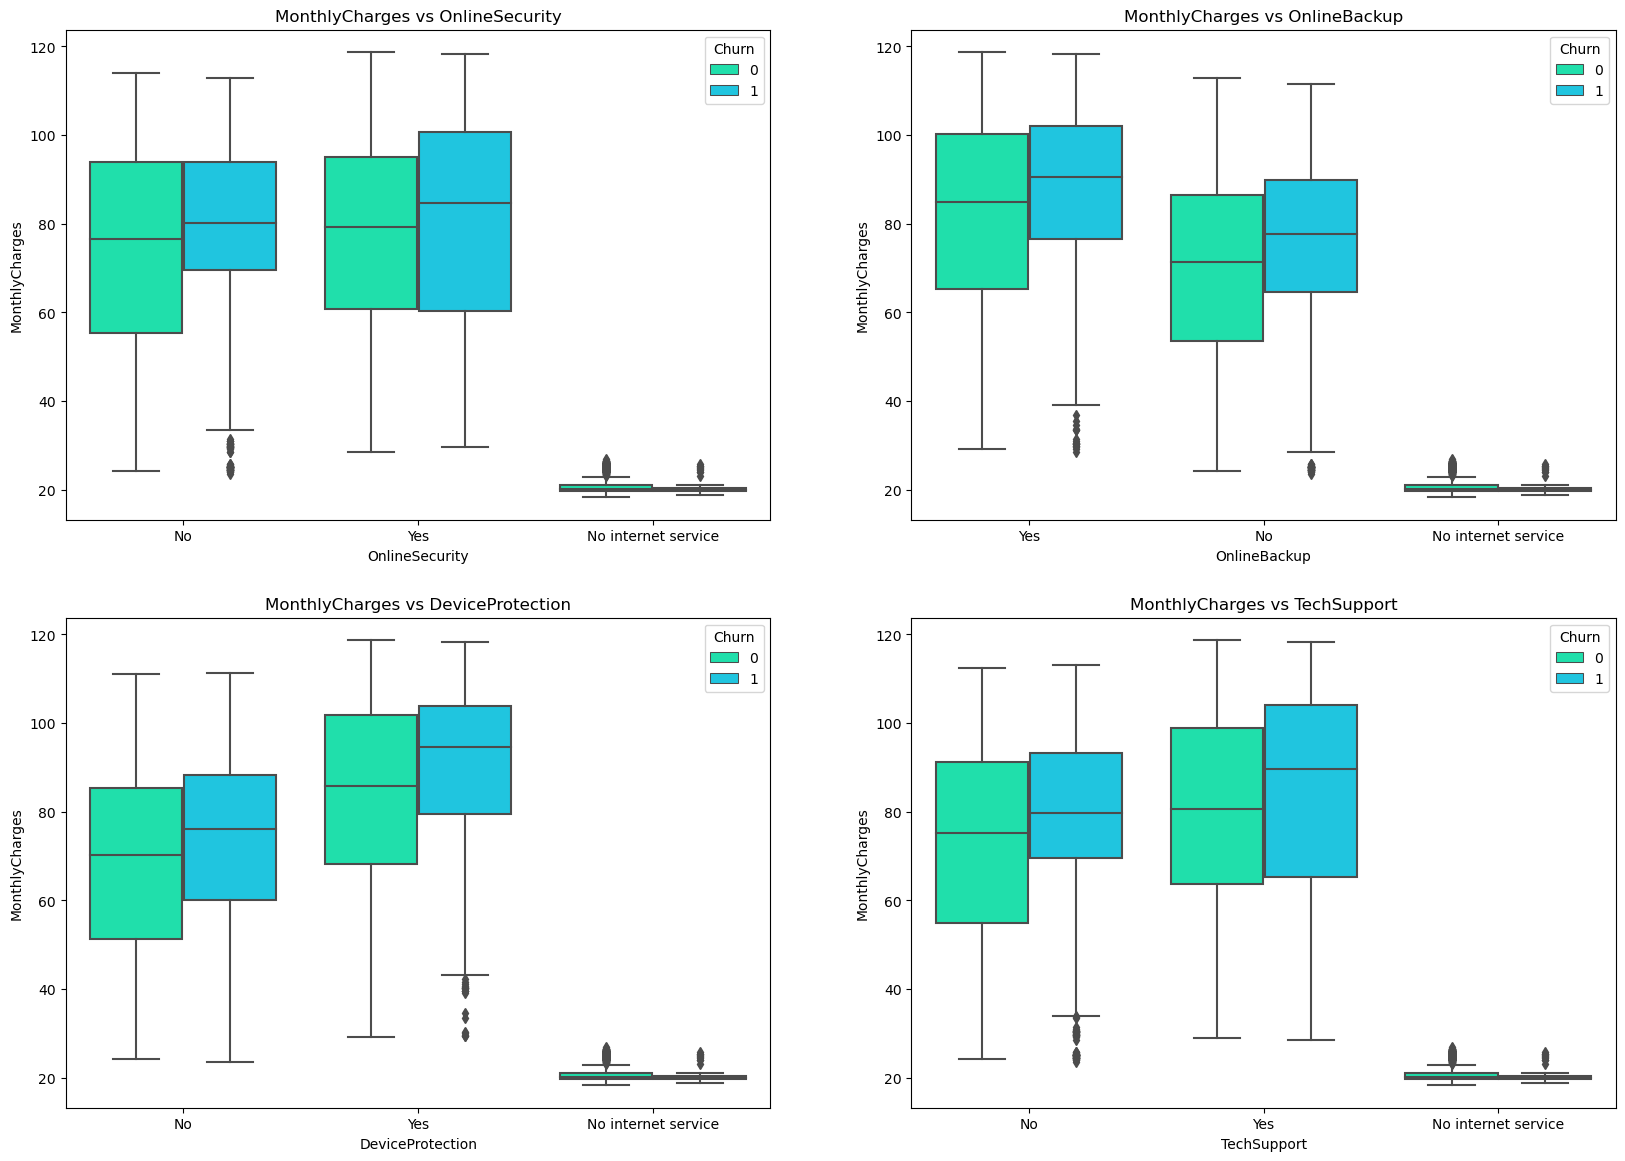

In [41]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = l2[i - 4],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors)
    plt.title('MonthlyCharges vs ' + l2[i-4])

## Yorumlar

* OnlineSecurity, OnlineBackup, DeviceProtection ve TechSupport için değer aralığı yaklaşık 50 ila 100 arasındadır.

* Bu hizmetlere abone olan müşteriler, muhtemelen MonthlyCharges nedeniyle aboneliğini iptal etmeyi düşünmüyorlar çünkü abonelikten çıkıp devam eden müşterilerin değer aralığı hemen hemen aynı!

### MonthlyCharges vs Group 3 : Contract | PaperlessBilling | PaymentMethod 

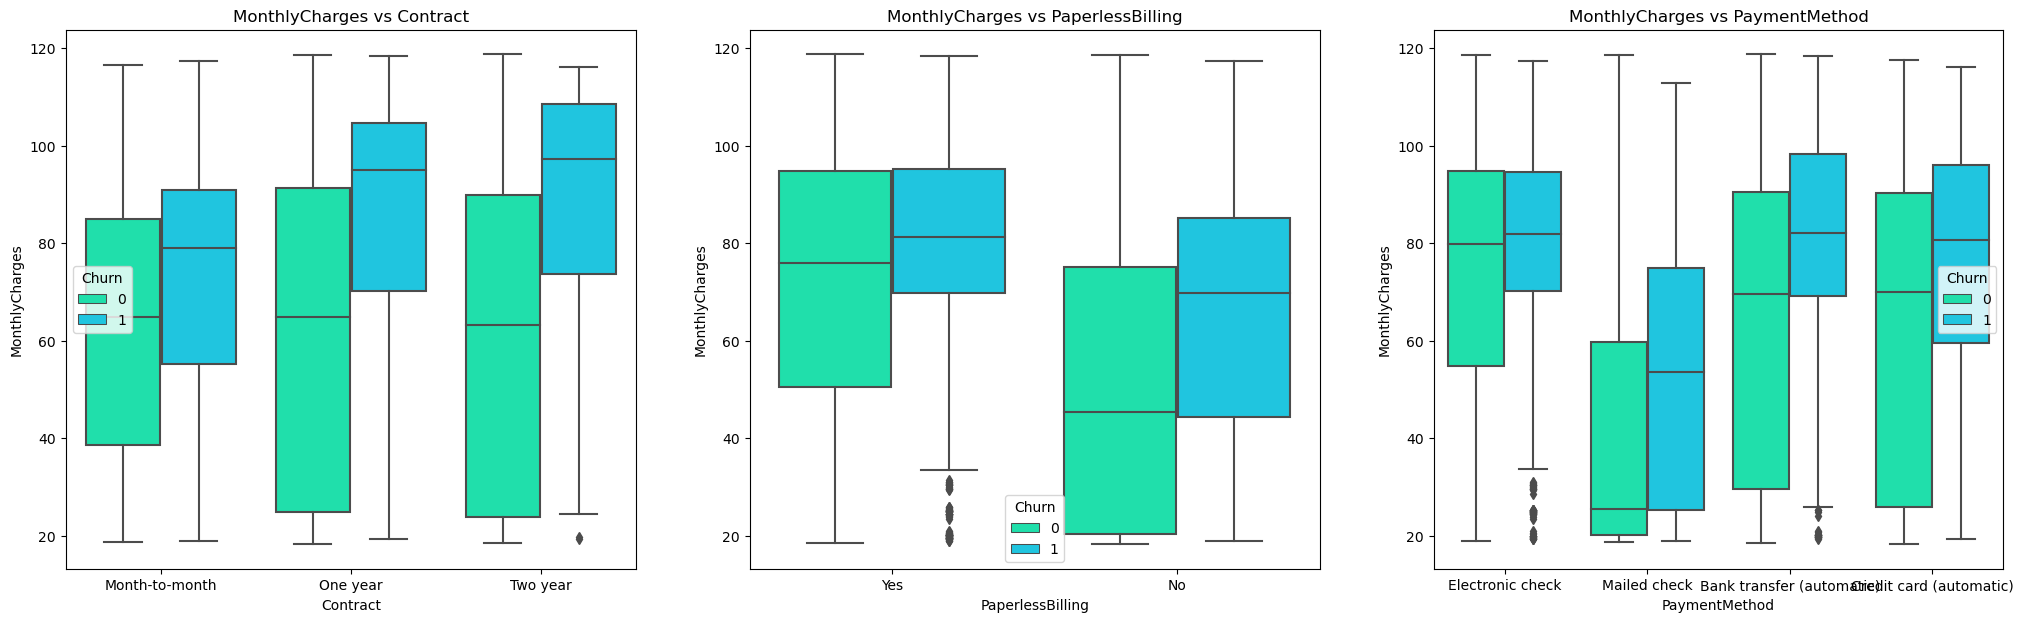

In [42]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

for i in range(len(l3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = l3[i],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors)
    title = 'MonthlyCharges vs ' + l3[i]
    plt.title(title)

### Yorumlar

* Aylık Ücretlerin alt limiti Aydan Aya sözleşme için Bir yıllık ve İki yıllık sözleşmelerden daha yüksektir. Ancak Aylık sözleşmelerde hizmeti bırakan müşterilerin alt limiti daha düşüktür.

* Elektronik çekin alt limiti çok yüksektir ve müşterilerin onu kullanmaktan vazgeçmesine neden olabilecek çok büyük bir faktör olabilir!

* Posta çeki ise ayrılan ve devam eden müşterilerin en düşük başlangıç değerlerine sahiptir.

## TotalCharges vs Group 1 : Customer Information : gender | SeniorCitizen | Partner | Dependents 

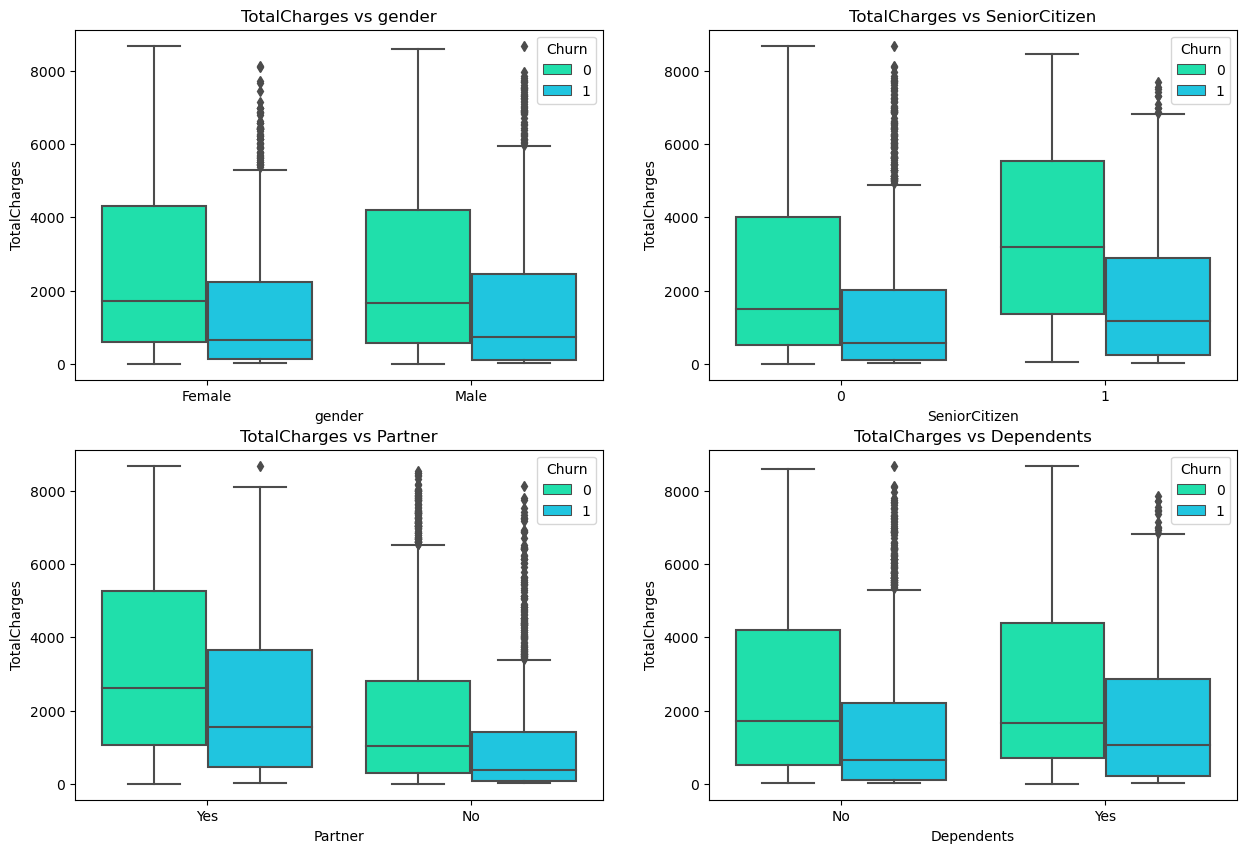

In [43]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = l1[i],y = 'TotalCharges',data = df,hue = 'Churn',palette = colors)
    plt.title('TotalCharges vs ' + l1[i])

### Yorumlar

* Erkek ve kadın müşteriler için Toplam Ücretler tamamen aynıdır! Hizmete devam eden SeniorCitizens(KıdemliVatandaşların) Toplam Ücret başlangıç ve kapanış değerleri daha yüksektir.

* Eşleriyle birlikte yaşayan müşterilerin Toplam Ücret ortalama değeri, yalnız yaşayanlara kıyasla daha yüksektir!

## TotalCharges vs Group 2: Services Subscribed by the Customer : PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies 


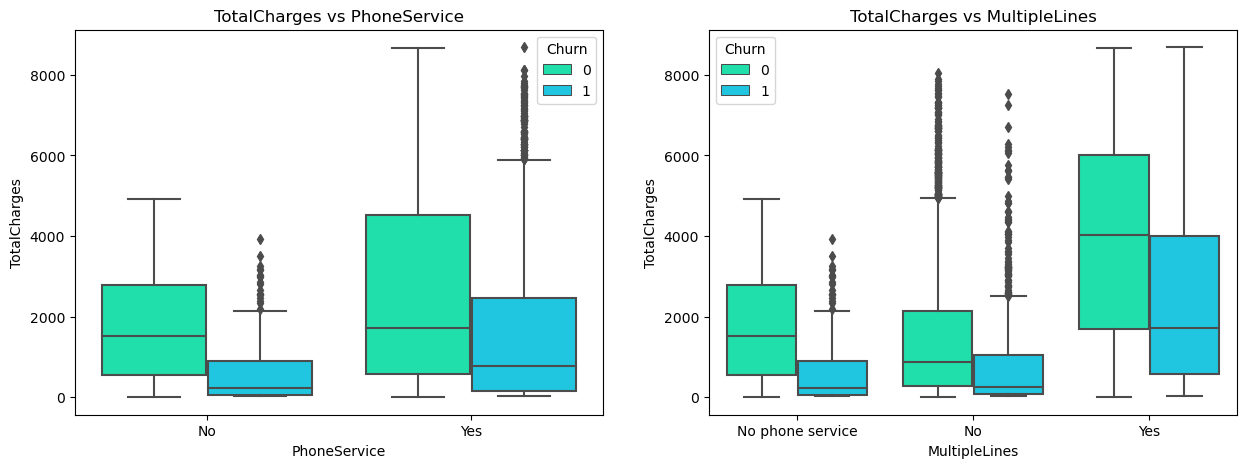

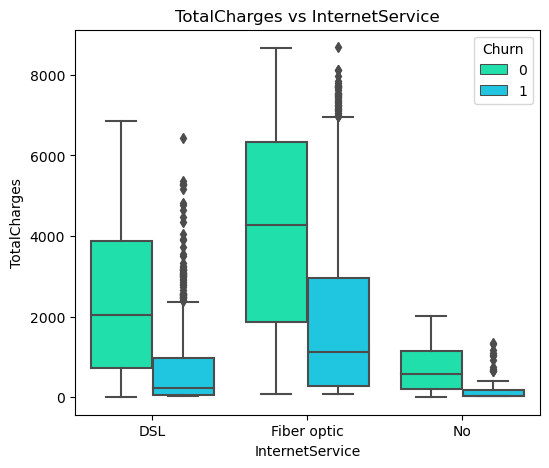

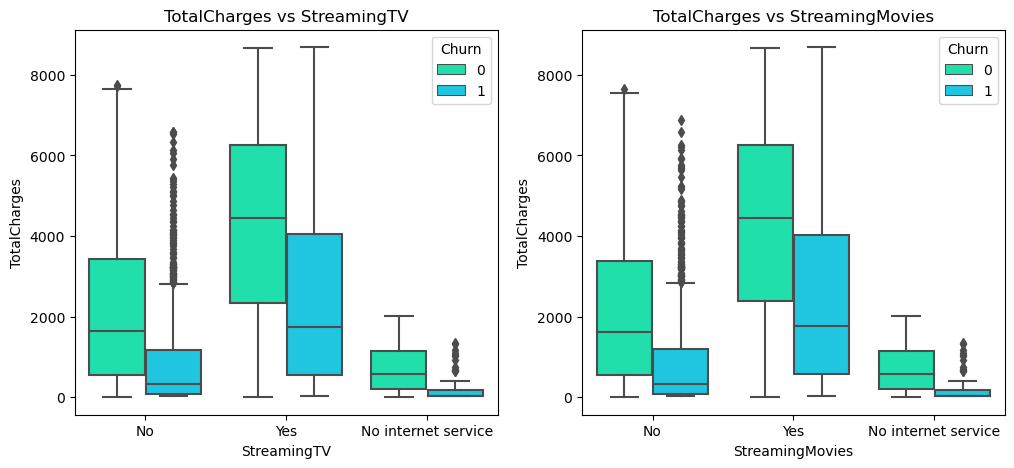

In [44]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i],y = 'TotalCharges',data = df,hue = 'Churn',palette = colors)
    plt.title('TotalCharges vs ' + l2[i])

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = l2[2],y = 'TotalCharges',data = df,hue = 'Churn',palette = colors)
plt.title('TotalCharges vs ' + l2[2])
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i + 3],y = 'TotalCharges',data = df,hue = 'Churn',palette = colors)
    plt.title('TotalCharges vs ' + l2[i + 3])

### Yorumlar

* TelefonServis Toplam Ücretleri 0 - 4000 arasında değişmektedir. Ancak müşteriler, Toplam Ücretler nedeniyle Telefon Servisi hakkında 1000 civarından itibaren 2. düşüncelere sahip olmaya başlarlar.

* Benzer şekilde müşteriler MultipleLines'a 2000 civarında ödeme yapmaktan çekinmeye başlıyor. Ancak bazı müşteriler, MultipleLines'a 6000 civarında bir değer ödedikleri için umutsuz görünüyorlar!

* Fiber Optik kablo ödemesine gelince, müşteriler 2000 civarında ödeme yaparak ürünleri test ediyor!

* Fiber Optik, StreamingTV ve StreamingMovies'e benzer şekilde hizmetlere devam eden müşteriler 3000 - 6000 arasında ödeme yapar.

## TotalCharges vs Group 2: Services Subscribed by the Customer : OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport |


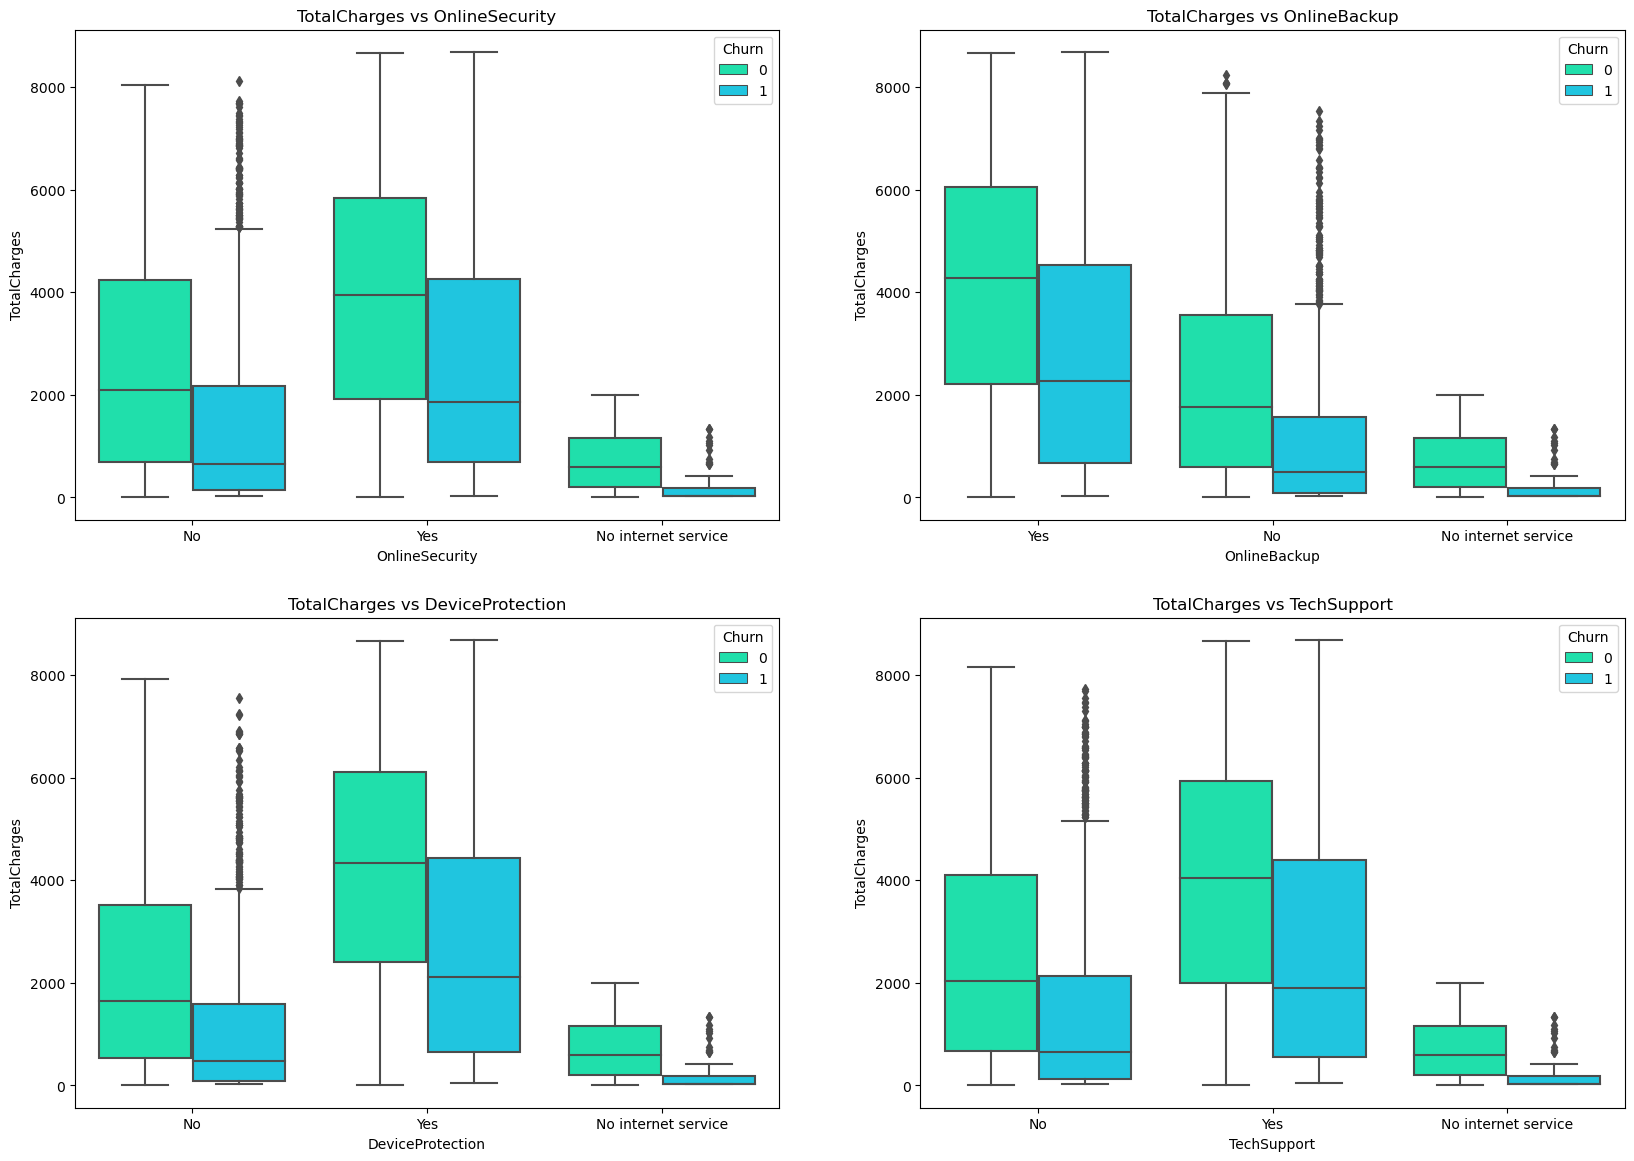

In [45]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = l2[i - 4],y = 'TotalCharges',data = df,hue = 'Churn',palette = colors)
    plt.title('TotalCharges vs ' + l2[i-4])

### Yorumlar
* Yukarıda belirtilen tüm özellikler için müşteriler, 2000 yılı civarında bunlar için ödeme yapma konusunda şüpheci olmaya başlıyor. Kaybedilen müşterilerin bu medyan değeri, bu hizmeti sürdüren müşterilerin alt sınırına çok yakındır.

* Abonelikten çıkmayan müşteriler 2000 - 6000 arası Toplam Ücret ödemeye hazırdır.

## TotalCharges vs Group 3 : Contract | PaperlessBilling | PaymentMethod |

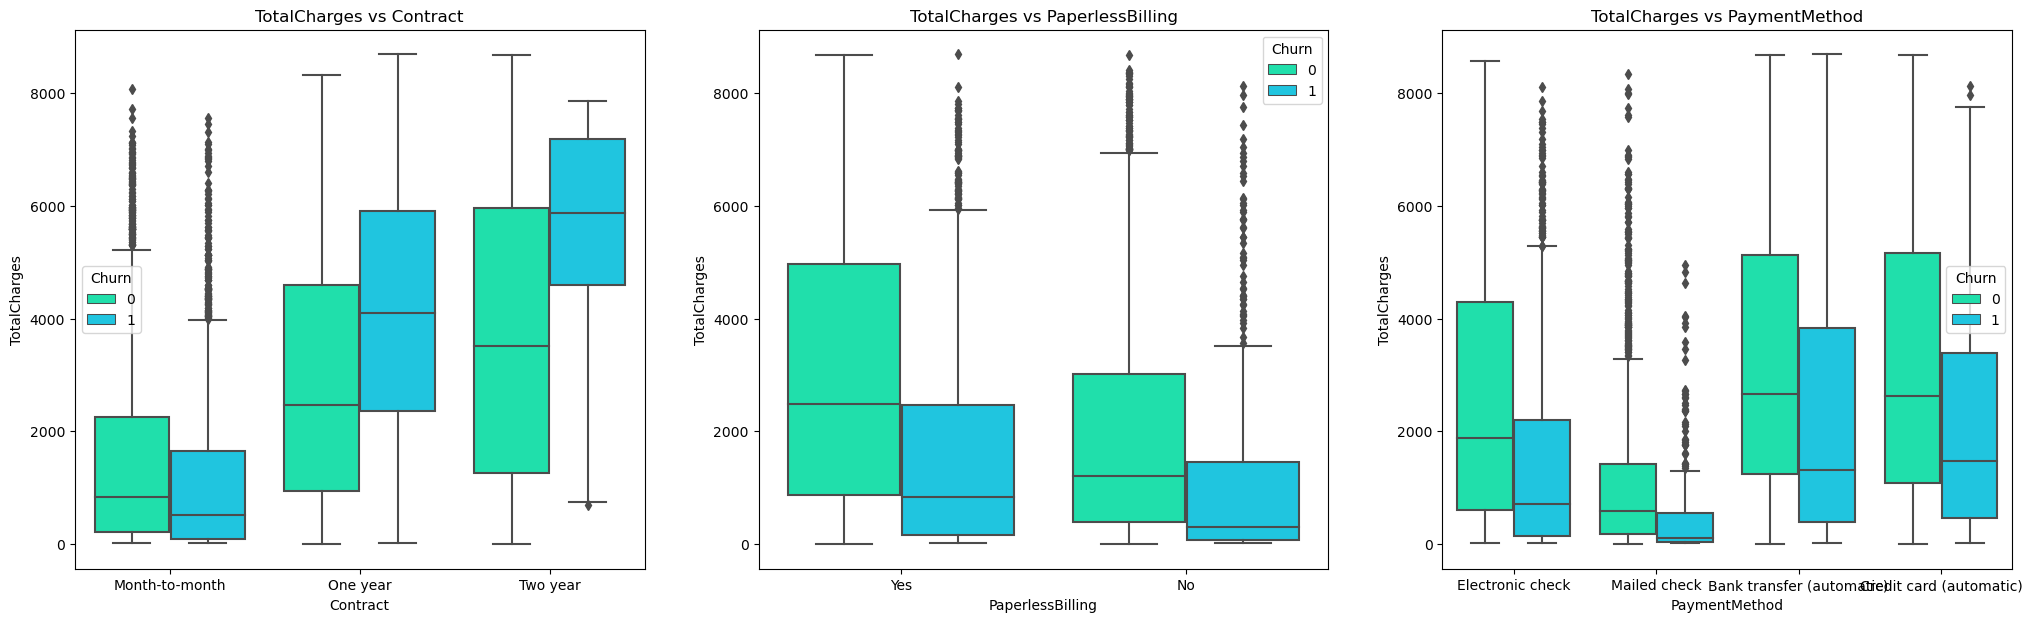

In [46]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

for i in range(len(l3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = l3[i],y = 'TotalCharges',data = df,hue = 'Churn',palette = colors)
    plt.title('TotalCharges vs ' + l3[i])

### Yorumlar

* Bir yıllık ve iki yıllık sözleşmeli hizmetlerden vazgeçmeye karar veren müşterilerin ortalama değerleri 4000 ve 6000 civarında yüksek. İki yıllık sözleşmeli müşterilerden bazıları 7000 civarında ödeme bile yaptı.

* PaymentMethod için müşteriler 0 - 2000 arası daha kısa bir aralık için Elektronik çek kullanarak ödeme yapmaya şüpheyle yaklaşırken, Banka havalesi (otomatik) ve Kredi Kartı (otomatik) için bu aralık 0 - 4000 civarındadır.

# Feature Engineering

In [47]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df.drop(columns = ['MonthlyCharges_Group','TotalCharges_Group'], inplace = True)

df['tenure'] = mms.fit_transform(df[['tenure']])
df['MonthlyCharges'] = mms.fit_transform(df[['MonthlyCharges']])
df['TotalCharges'] = mms.fit_transform(df[['TotalCharges']])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,0.014,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0.115,0.003,0
1,Male,0,No,No,0.472,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,0.385,0.218,0
2,Male,0,No,No,0.028,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,0.354,0.012,1
3,Male,0,No,No,0.625,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),0.239,0.212,0
4,Female,0,No,No,0.028,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0.522,0.017,1


### Yorumlar

Makine öğrenimi modeli, özelliklerin değerlerinin birimlerini anlamıyor. Girdiyi basit bir sayı gibi ele alır ancak bu değerin gerçek anlamını anlamaz. Dolayısıyla verileri ölçeklendirmek gerekli hale geliyor.


* Veri ölçeklendirme için 2 seçeneğimiz var: 1) Normalleştirme 2) Standardizasyon.

* Algoritmaların çoğu, verilerin normal (Gaussian) dağıldığını varsaydığından, verileri normal dağılım göstermeyen özellikler için normalleştirme yapılır ve değerleri karşılaştırıldığında değerleri çok büyük veya çok küçük olan normal dağılımlı özellikler için standardizasyon yapılır. diğer özelliklere.

* Normalleştirme: Kullanım süresi, MonthlyCharges ve TotalCharges özellikleri sağa çarpık ve iki modlu bir veri dağılımı sergiledikleri için normalleştirildi.

* Standardizasyon: Yukarıdaki veriler için hiçbir özellik standartlaştırılmamıştır.

### Correlation Matrix

<Axes: >

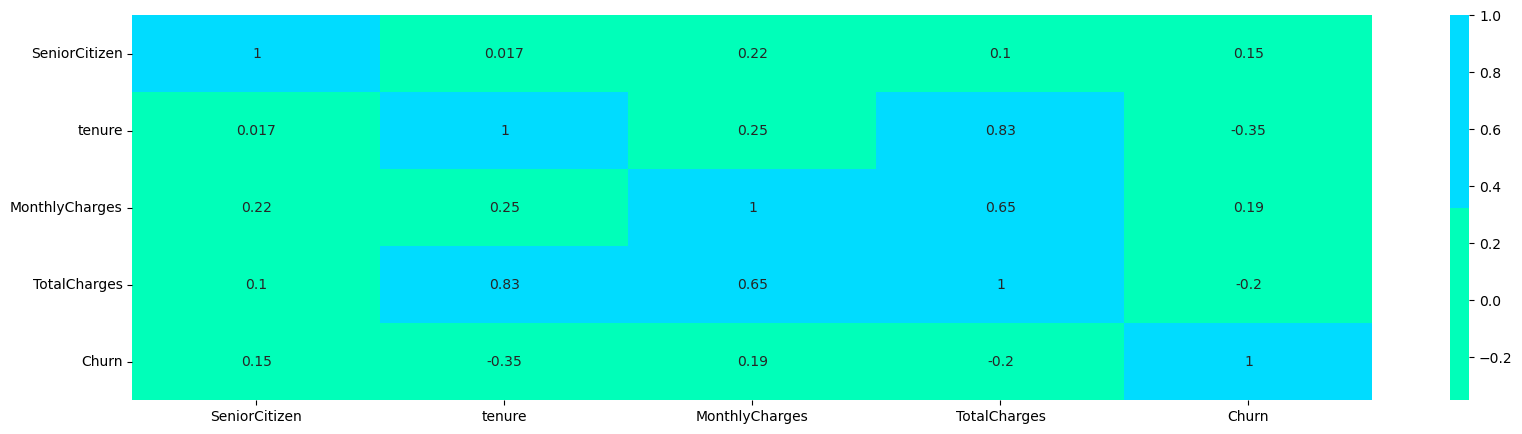

In [52]:
plt.figure(figsize = (20,5))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(),cmap = colors,annot = True)

Text(0.5, 1.0, 'Correlation w.r.t Outcome')

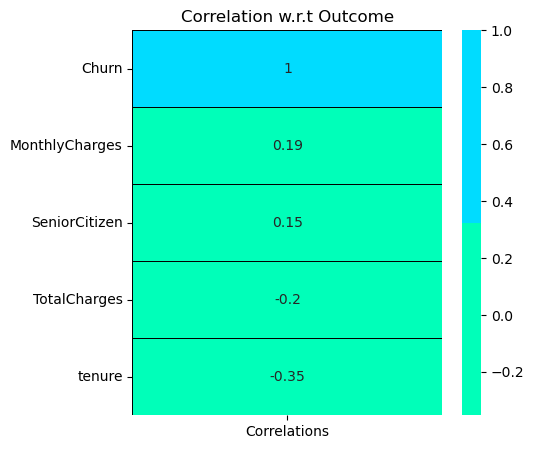

In [54]:
corr = df.select_dtypes(include=[np.number]).corrwith(df['Churn']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t Outcome')

### Feature Selection 

In [55]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df = df.copy(deep = True)
text_data_features = [i for i in list(df.columns) if i not in list(df.describe().columns)]

print('Label Encoder Transformation')
for i in text_data_features :
    df[i] = le.fit_transform(df[i])
    print(i,' : ',df[i].unique(),' = ',le.inverse_transform(df[i].unique()))

Label Encoder Transformation
gender  :  [0 1]  =  ['Female' 'Male']
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [56]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,0.014,0,1,0,0,2,0,0,0,0,0,1,2,0.115,0.003,0
1,1,0,0,0,0.472,1,0,0,2,0,2,0,0,0,1,0,3,0.385,0.218,0
2,1,0,0,0,0.028,1,0,0,2,2,0,0,0,0,0,1,3,0.354,0.012,1
3,1,0,0,0,0.625,0,1,0,2,0,2,2,0,0,1,0,0,0.239,0.212,0
4,0,0,0,0,0.028,1,0,1,0,0,0,0,0,0,0,1,2,0.522,0.017,1


In [57]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif

Text(0.5, 1.0, 'Selection of Categorical Features')

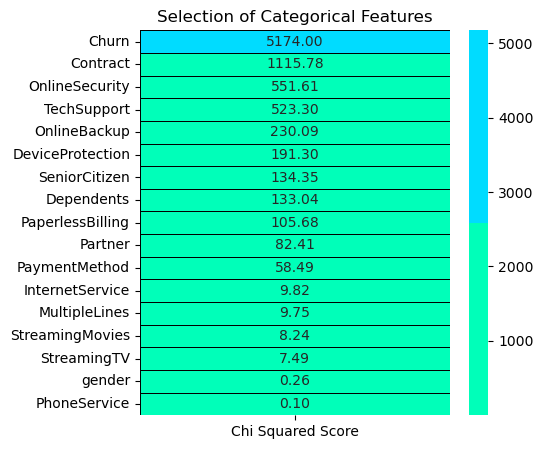

In [66]:
features = df.loc[:,cat_cols]
target = df.loc[:,'Churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f')
plt.title('Selection of Categorical Features')

* PhoneService, gender, StreamingTV, StreamingMovies, MultipleLines ve InternetService, Churn ile çok düşük bir ilişki göstermektedir.

### Feature Selection for Numerical Features :

In [67]:
from sklearn.feature_selection import f_classif

Text(0.5, 1.0, 'Selection of Numerical Features')

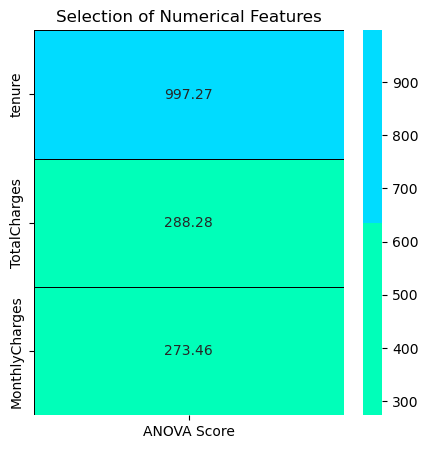

In [68]:
features = df.loc[:,num_cols]
target = df.loc[:,'Churn']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f')
plt.title('Selection of Numerical Features')

### Yorumlar

ANOVA testine göre ANOVA puanının değeri ne kadar yüksekse, özelliğin önemi de o kadar yüksektir.

Yukarıdaki sonuçlardan modelleme için tüm sayısal özellikleri dahil etmemiz gerekir.

In [69]:
df.drop(columns = ['PhoneService', 'gender','StreamingTV','StreamingMovies','MultipleLines','InternetService'],inplace = True)
df.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,0.014,0,2,0,0,0,1,2,0.115,0.003,0
1,0,0,0,0.472,2,0,2,0,1,0,3,0.385,0.218,0
2,0,0,0,0.028,2,2,0,0,0,1,3,0.354,0.012,1
3,0,0,0,0.625,2,0,2,2,1,0,0,0.239,0.212,0
4,0,0,0,0.028,0,0,0,0,0,1,2,0.522,0.017,1


### Balancing

Dengesiz verilerle başa çıkmak için 2 seçenek vardır:

* Yetersiz örnekleme: Hedef değişkenin çoğunluk örneklerini kırpın.

* Aşırı Örnekleme : Hedef değişkenin azınlık örneklerini çoğunluk örneklerine yükseltin.

* Düşük örnekleme ve aşırı örnekleme ile deneme yanılma yaptıktan sonra, aşırı örneklemeye karar verdik!

Veri dengeleme için imblearn kullanacağız.
pip statement : pip install imbalanced-learn

In [71]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [72]:
over = SMOTE(sampling_strategy = 1)

f1 = df.iloc[:,:13].values
t1 = df.iloc[:,13].values

f1, t1 = over.fit_resample(f1, t1)
Counter(t1)

Counter({0: 5174, 1: 5174})

# MODELING

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [74]:
x_train, x_test, y_train, y_test = train_test_split(f1, t1, test_size = 0.20, random_state = 17)

In [75]:
def model(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    plt.show()

def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

### XGB CLASSIFIER

In [77]:
from xgboost import XGBClassifier

classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

In [78]:
model(classifier_xgb,x_train,y_train,x_test,y_test)

Cross Validation Score :  89.99%
ROC_AUC Score :  82.28%


              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1025
           1       0.80      0.86      0.83      1045

    accuracy                           0.82      2070
   macro avg       0.83      0.82      0.82      2070
weighted avg       0.83      0.82      0.82      2070



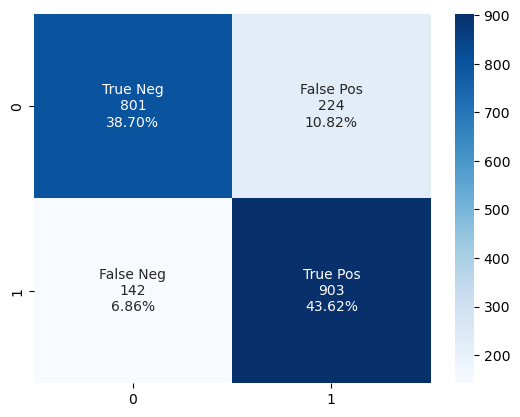

In [79]:
model_evaluation(classifier_xgb,x_test,y_test)

### LGBM Classifier

In [80]:
from lightgbm import LGBMClassifier

classifier_lgbm = LGBMClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000, force_col_wise='true',verbose=-1)

In [81]:
model(classifier_lgbm,x_train,y_train,x_test,y_test)


Cross Validation Score :  90.19%
ROC_AUC Score :  82.19%


              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1025
           1       0.80      0.86      0.83      1045

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070



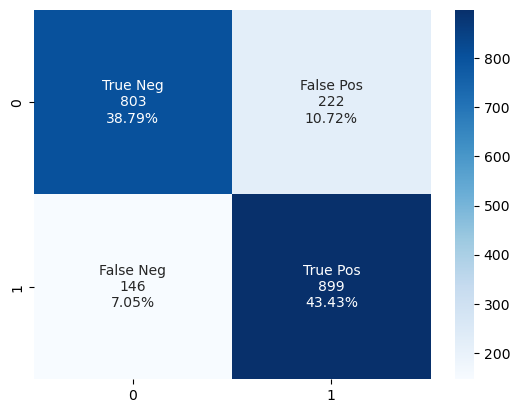

In [82]:
model_evaluation(classifier_lgbm,x_test,y_test)

### Random Forest Classifier

In [83]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)


In [84]:
model(classifier_rf,x_train,y_train,x_test,y_test)


Cross Validation Score :  85.72%
ROC_AUC Score :  77.13%


              precision    recall  f1-score   support

           0       0.81      0.70      0.75      1025
           1       0.74      0.84      0.79      1045

    accuracy                           0.77      2070
   macro avg       0.78      0.77      0.77      2070
weighted avg       0.78      0.77      0.77      2070



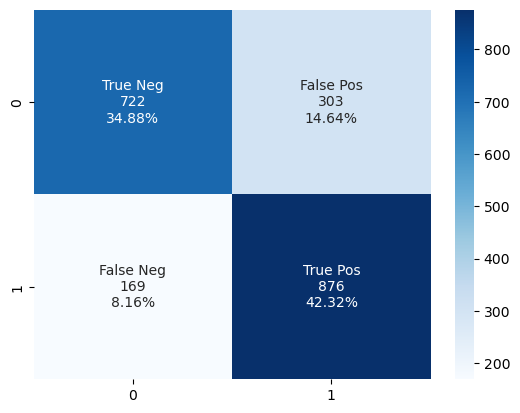

In [85]:
model_evaluation(classifier_rf,x_test,y_test)


### Decision Tree Classifier

In [86]:
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)


In [87]:
model(classifier_dt,x_train,y_train,x_test,y_test)


Cross Validation Score :  84.36%
ROC_AUC Score :  76.54%


              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1025
           1       0.75      0.80      0.78      1045

    accuracy                           0.77      2070
   macro avg       0.77      0.77      0.77      2070
weighted avg       0.77      0.77      0.77      2070



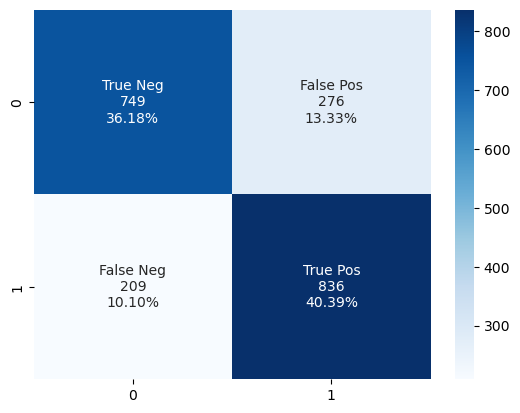

In [88]:
model_evaluation(classifier_dt,x_test,y_test)

# Summary

* 3 tür müşteri hedeflenmelidir : SeniorCitizen, Living with a Partner, living all alone!

* SeniorCitizen müşterilerinin sayısı az ancak Monthly Charges alt limitleri diğer müşterilere göre daha yüksektir. Bu nedenle Senior Citizen müşterileri en yüksek doları ödemeye hazırdır ancak bu düzeyde hizmete ihtiyaçları vardır. Partnerli müşteriler ve yalnız yaşayan müşteriler Aylık Ücreti(Monthly Charges) 65'in altında olan hizmetleri tercih etmektedir.

* İlk 6 aylık görev süresi(tenure 1st 6months) boyunca, bu dönem müşteriler için en kritik ve belirsiz olduğundan, OnlineSecurity, OnlineBackup, DeviceProtection ve TechSupport konularına kapsamlı bir şekilde odaklanması gerekiyor. Bu hizmetler için 40 - 50 aylık kayıp süresini düşürmeleri gerekiyor!

* Müşteriler için sağlam bir destek hizmetleri hattı oluşturduktan sonra, Telefon Hizmeti ve İnternet Hizmeti için sırasıyla MultipleLines ve Fiber Optik kabloların kullanımını artırmaları gerekiyor.   Ancak bu 2 hizmetin önündeki en büyük engel, MonthlyCharges'da 75+'nin başlangıç noktasıdır.

* Bu nedenle, Telefon Hizmeti ve İnternet Hizmeti için sağlanan, bu Aylık Ücretlerin ortalamasının 100 - 120 aralığında olacağı seçenek kombinasyonlarını oluşturmaları gerekir:
-- No MultipleLines + OpticFiber
-- MultipleLines + DSL

* Bu, ortalama Aylık Ücreti muhtemelen 60 - 70 olan Çoklu Hat Yok + DSL(No MultipleLines+ DSL) kombinasyonunu seçme seçeneğini tamamen ortadan kaldıracağından kullanıcının ortalama gelirini artıracaktır!


* StreamingTV ve StreamingMovies'in uygun fiyatlı hale getirilmesi ve aynı zamanda kullanım süresinin kısaltılması gerekiyor. Bu hizmetlerin içeriği her türden müşteriyi hedeflemelidir. Bunun kolay ve sorunsuz bir Ödeme Yöntemi ile takip edilmesi gerekir.


* Yüksek kayıp nedeniyle ödeme amaçlı Elektronik çeke son verilmesi ve tamamen Banka Havalesi (otomatik) ve Kredi Kartına (otomatik) odaklanması gerekiyor! Ancak, bu 2 Ödeme Yöntemi için ortalama kayıp süresini 20 ayın üzerinde azaltmaları istenecektir; bu da Elektronik çekin kullanım süresinin iki katıdır. 


* Aylık Ücretlerde Elektronik çekin alt limiti 60 civarındayken, Banka Havalesi (otomatik) ve Kredi Kartının (otomatik) alt limiti 20 civarındadır. Kağıtsız Faturalandırma, 60 başlangıç noktasıyla başka bir pahalı özelliktir; diğer seçenekler ise MonthlyCharges'da 20'den başlayan ucuzdur.

